
---

# __REALISEZ UNE ANALYSE DE SENTIMENTS GRACE AU DEEP LEARNING - NOTEBOOK 2 POUR MODELES AVANCES__

---


## SOMMAIRE

- [CHARGEMENT DES DONNEES](#chargement-des-donnees)

- [ETAPE 6 : FONCTIONS UTILES POUR MODELES AVANCES](#etape-6--fonctions-utiles-pour-modeles-avances)

- [ETAPE 7 : MODELE 1 MULTI LAYER PERCEPTRON MLP](#etape-7--modele-1-multi-layer-perceptron-mlp)

- [ETAPE 8 : MODELE 2 BI-LSTM](#etape-8--modele-2-bi-lstm)

- [ETAPE 9 : MODELE 3 BERT](#etape-9--modele-3-bert)

- [ETAPE 10 : INDUSTRIALISATION ET SUIVI]()




---

## __CHARGEMENT DES DONNEES__

---

In [1]:
!which python
!python --version

/opt/homebrew/Caskroom/miniforge/base/envs/sentiment-oc/bin/python
Python 3.11.13


In [2]:
# __Base__
import os, time, json, gc, math, random
import numpy as np
import pandas as pd

# __Visualisation__
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8, 6)

# __Scikit-learn : m√©triques & split__
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)

# __TensorFlow / Keras (MLP et Bi-LSTM)__
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Limitation CPU pour TensorFlow (√©vite la surcharge sur Mac M4)
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

# __PyTorch (BERT)__
import torch
from torch.utils.data import Dataset, DataLoader

# __Hugging Face Transformers (BERT en PyTorch)__
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer, TrainingArguments,
    DataCollatorWithPadding,
    get_linear_schedule_with_warmup
)

# __MLflow (tracking des exp√©riences)__
import mlflow
import mlflow.keras
import mlflow.pytorch

# __Optionnel : Keras Tuner__
try:
    import keras_tuner as kt
except ImportError:
    print("Keras Tuner non install√© - `pip install keras-tuner` si besoin.")

# __Config : seed et device__
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device PyTorch : {DEVICE}")
print("TensorFlow:", tf.__version__)
try:
    import transformers
    print("Transformers:", transformers.__version__)
    print("PyTorch:", torch.__version__)
except Exception:
    pass

# __R√©duire le verbiage TensorFlow__
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# __Configurer MLflow pour ce projet__
mlflow.autolog(disable=True)              # coupe tout autolog global
import mlflow.keras, mlflow.pytorch       # on garde les saveurs pour le logging manuel

# Optionnel: s'assurer de logger dans le bon dossier √† la racine du projet
mlflow.set_tracking_uri("file:///Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/mlruns")
mlflow.set_experiment("Sentiment Analysis - Mod√®les Avanc√©s")

Keras Tuner non install√© - `pip install keras-tuner` si besoin.
Device PyTorch : mps
TensorFlow: 2.19.1
Transformers: 4.55.0
PyTorch: 2.8.0


<Experiment: artifact_location=('/Users/michele/Documents/PERSO/FORMATION INGENIEUR '
 'IA/PROJET7/notebooks/../mlruns/778421182583914328'), creation_time=1756290064671, experiment_id='778421182583914328', last_update_time=1756290064671, lifecycle_stage='active', name='Sentiment Analysis - Mod√®les Avanc√©s', tags={}>


---

## __ETAPE 6 : FONCTIONS UTILES POUR MODELES AVANCES__

---

Cette √©tape introduit les mod√®les de Deep Learning plus puissants afin d‚Äôam√©liorer l‚Äôanalyse de sentiments sur notre corpus de 16k tweets.  

__Les objectifs sont__ :  

- Impl√©menter au moins 3 architectures :  
  - Mod√®le Keras simple comme _MLP (Multi Layer Perceptron)_  
  - _Bi-LSTM_ pour capter la dynamique s√©quentielle des tweets  
  - _Mod√®le BERT_  
  - _Optionnel_ : `USE` (Universal Sentence Encoder), si faisable techniquement  
- Rester __coh√©rent dans l‚Äô√©valuation__ (m√™mes m√©triques que l‚Äô√©tape 5 : `accuracy`, `precision`, `recall`, `f1`, `AUC`)  
- __Analyser les erreurs__ en d√©taillant les faux positifs et faux n√©gatifs, 
- __Comparer__ proprement avec les mod√®les baselines (`Logistic Regression`, `SVM`, `Naive Bayes`)  

__Rappel des embeddings utilis√©s__ :  

| __Embedding__       | __Fichier `.parquet` utilis√©__      | __Justification__                                                                 |
|---------------------|--------------------------------------|-----------------------------------------------------------------------------------|
| `count`             | `tweets_16k_clean_stem.parquet`      | _Simple bag-of-words_ : besoin de texte √©pur√© ‚Üí stemming adapt√©                   |
| `tfidf`             | `tweets_16k_clean_stem.parquet`      | _Mesure d'importance des mots_ : le stemming √©vite la dilution des racines       |
| `w2v`               | `tweets_16k_clean_lem.parquet`       | _Word2Vec pr√©entra√Æn√©_ : la lemmatisation pr√©serve les relations s√©mantiques      |
| `ft`                | `tweets_16k_clean_lem.parquet`       | _FastText (subwords)_ : lemmatization = meilleur alignement avec les vecteurs     |
| `bert`              | `tweets_16k_clean_emoji.parquet`     | _Mod√®le pr√©entra√Æn√©_ sur du texte naturel avec ponctuation et emojis              |


__Suivi des hyperparam√®tres par mod√®le et embedding__ :

| __Mod√®le__     | __Embedding__ | __Input dim__ | __max_len__ | __Optimizer__ | __Epochs__ | __Batch size__ | __Dropout__ | __Remarques__                                   |
|----------------|---------------|---------------|-------------|----------------|-------------|----------------|--------------|-------------------------------------------------|
| `MLP`          | `count`       | `X_count.shape[1]` | n/a         | `Adam`         | 10          | 32             | 0.5          | Dense(64), activation ReLU                      |
| `MLP`          | `tfidf`       | `X_tfidf.shape[1]` | n/a         | `Adam`         | 10          | 32             | 0.5          | Dense(64), activation ReLU                      |
| `Bi-LSTM`      | `w2v`         | (timesteps, dim)   | 100         | `Adam`         | 10          | 32             | 0.3          | 1 BiLSTM layer + Dense output                  |
| `Bi-LSTM`      | `ft`          | (timesteps, dim)   | 100         | `Adam`         | 10          | 32             | 0.3          | 1 BiLSTM layer + Dense output                  |
| `BERT`         | `bert`        | handled by tokenizer | 128     | `AdamW`        | 3           | 16             | 0.1          | `TFBertForSequenceClassification`               |

Dans les phases d‚Äôoptimisation, nous ajusterons ces hyperparam√®tres √† l‚Äôaide de m√©thodes simples (callbacks : `EarlyStopping`, `ReduceLROnPlateau`) et, √©ventuellement, de mani√®re exploratoire ou selon les mod√®les, par une recherche syst√©matique (ex. KerasTuner) afin d‚Äôam√©liorer les performances.

__Etapes √† couvrir par mod√®le avanc√©__

- √âtape 1 ‚Äî __Choix de l'embedding__ :
  - Choisir l‚Äô`embedding` le plus adapt√© au mod√®le
  - Charger les donn√©es selon
  - V√©rifier l‚Äôalignement avec `y_train`, `y_val`, `y_test`

- √âtape 2 ‚Äî __Pr√©paration des donn√©es__ :
  - Appliquer un `reshape`, `padding` ou une normalisation si n√©cessaire
  - V√©rifier les dimensions : `X.shape`, `y.shape`


- √âtape 3 ‚Äî __D√©finition du mod√®le__ :
  - D√©finir la structure du mod√®le (ex. ``Sequential``, ``Functional``, ``BERTClassifier``)
  - Choisir une configuration de base (``optimizer``, ``loss``, ``batch_size``, ``epochs``)


- √âtape 4 ‚Äî __Entra√Ænement__ :
  - Entra√Æner sur `X_train`, `y_train`
  - √âvaluer sur `X_val`
  - Sauvegarder le mod√®le dans `models/keras/` ou `models/bert/`

- √âtape 5 ‚Äî __√âvaluation__ :
  - Pr√©dire sur `X_val` et `X_test`
  - Calculer les m√©triques :
    - `accuracy`
    - `precision`, `recall`, `f1-score`
    - `roc_auc_score`
    - `classification_report`
    - `seuil optimal` (avec `precision_recall_curve`)

- √âtape 6 ‚Äî __Visualisations √† afficher et √† sauvegarder dans `models/artifacts/<nom_modele>/`__ :
  - `courbe Precision-Recall` (`val` et `test`)
  - `courbe ROC` (`val` et `test`)
  - `matrice de confusion` (`val` et `test`)
  - `courbe d'apprentissage` (`loss` et `accuracy` par epoch)

- √âtape 7 ‚Äî __Logging m√©tier__ :
  - Enregistrer les `hyperparam√®tres` utilis√©s
  - Logger les `temps d'entra√Ænement` et `temps de pr√©diction`
  - G√©n√©rer un fichier ``log`` texte dans `reports/logs/<nom_modele>.txt`

- √âtape 8 ‚Äî __Analyse m√©tier__ :
  - Identifier les erreurs : `faux positifs` et `faux n√©gatifs`
  - Interpr√©ter les r√©sultats selon la probl√©matique
  - Justifier le score retenu pour la comparaison finale (ex. `F1` vs `accuracy`)

- √âtape 9 ‚Äî __Optimisation__ : 
  - Modifier les `hyperparam√®tres`
  - R√©entra√Æner, logger et comparer avec la version de base

- √âtape 10 ‚Äî __Synth√®se__ :
  - Compl√©ter le tableau de comparaison
  - S√©lectionner la meilleure version du mod√®le pour la suite


__Fonctions utiles pour automatiser__

| Fonction                | Utilit√© principale                             |
| ----------------------- | ---------------------------------------------- |
| `load_embedding_data()` | Charger proprement un `X` et `y`               |
| `get_run_name()`        | Avoir un nom unique pour le run/mod√®le         |
| `save_model()`      | Sauvegarder le mod√®le entra√Æn√© dans le bon sous-dossier |
| `evaluate_model()`      | Calculer toutes les m√©triques utiles           |
| `display_evaluation_report()`| Afficher un rapport complet           |
| `plot_...()`            | Visualiser et sauvegarder PR / ROC / confusion |
| `save_figure()` et `save_logs()`| Sauvegarder les plots et log texte avec les hyperparams|



### __Charger proprement X et y__

Charge proprement X et y depuis le r√©pertoire `data/processed/embeddings/` :

In [3]:
def load_embedding_data(X_name, y_name, base_path="/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/embeddings/"):
    import os, numpy as np, pandas as pd
    X_path = os.path.join(base_path, X_name)
    y_path = os.path.join(base_path, y_name)
    X = np.load(X_path) if X_name.endswith(".npy") else pd.read_parquet(X_path).values
    y = pd.read_parquet(y_path)["label"].values
    return X, y


### __G√©n√©rer un nom unique pour chaque run__

La fonction ``get_run_name()`` permet de cr√©er automatiquement un nom explicite pour chaque entra√Ænement de mod√®le, en combinant le type de mod√®le et ses hyperparam√®tres principaux.

Cela facilite :
- la navigation dans les runs MLflow
- l‚Äôenregistrement automatique des artefacts
- l‚Äôanalyse des essais et comparaisons

__Exemple__ :
```python
params = {"dropout": 0.3, "bs": 32}
run_name = get_run_name("bilstm", params)
print(run_name)  # "bilstm_dropout0.3_bs32"
```


In [4]:
def get_run_name(model_type, params: dict):
    """
    G√©n√®re un nom unique de run √† partir du type de mod√®le et des param√®tres cl√©s.
    """
    parts = [model_type]
    for k, v in params.items():
        parts.append(f"{k}{v}")
    return "_".join(parts)




### __Sauvegarde du mod√®le entra√Æn√©__

Une fois le mod√®le entra√Æn√©, il est essentiel de l‚Äôenregistrer dans le dossier ``models/`` pour pouvoir le recharger plus tard sans devoir le r√©entra√Æner.

Avant d‚Äôappeler la fonction, il faudra d√©finir la variable ``base_dir`` pour pointer vers le dossier ``models/`` :

```python
base_dir = "../models"
````
La syntaxe de la fonction :  

```python
save_model(model, model_name="MLP_count", backend="keras")
```

Param√®tres :
- `model` : objet du mod√®le entra√Æn√©
- `model_name` : nom du fichier √† sauvegarder (sans extension)
- `backend` : framework utilis√© :
    - "`keras`" pour un mod√®le Keras
    - "`torch`" pour un mod√®le PyTorch  

R√©sultat attendu :  
Le mod√®le sera sauvegard√© dans un sous-dossier selon le backend :
- Pour un mod√®le Keras : models/keras/MLP_count.h5
- Pour un mod√®le PyTorch : models/bert/MLP_count.pt  
_La fonction cr√©e automatiquement le r√©pertoire s‚Äôil n‚Äôexiste pas._    


In [5]:
import os

def save_model(model, model_name, backend="keras", base_dir="../models"):
    """
    Sauvegarde un mod√®le entra√Æn√© dans le bon sous-dossier selon le backend.
    
    Args :
        model : le mod√®le entra√Æn√© (Keras ou PyTorch)
        model_name : nom du fichier de sauvegarde (sans extension)
        backend : "keras" ou "pytorch"
        base_dir : dossier de base ("../models" par d√©faut)
    """
    # D√©terminer le sous-dossier
    if backend == "keras":
        save_path = os.path.join(base_dir, "keras", f"{model_name}.h5")
        model.save(save_path)
        print(f"Mod√®le Keras sauvegard√© : {save_path}")

    elif backend == "pytorch":
        save_path = os.path.join(base_dir, "bert", f"{model_name}.pt")
        torch.save(model.state_dict(), save_path)
        print(f"Mod√®le PyTorch sauvegard√© : {save_path}")

    else:
        raise ValueError("Backend non reconnu : choisir 'keras' ou 'pytorch'")


### __Evaluation du mod√®le__

√âvalue un mod√®le sur X_val ou X_test. Et calcule les principales m√©triques de classification :

- ``accuracy``
- ``precision``
- ``recall``
- ``f1-score``
- ``roc_auc`` (si ``y_proba`` est fourni)

Elle retourne un ``dict`` des scores, et peut afficher :

- le ``classification_report``
- la ``matrice de confusion``

__Exemple de retour__ :

```python
{
  "accuracy": 0.87,
  "precision": 0.88,
  "recall": 0.85,
  "f1": 0.86,
  "roc_auc": 0.92
}
```

In [6]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

def evaluate_model(y_true, y_pred, y_proba=None, verbose=True):
    """
    Calcule les m√©triques classiques d'√©valuation.
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            metrics["roc_auc"] = auc
        except:
            pass

    if verbose:
        print(classification_report(y_true, y_pred))
        print("Confusion Matrix :\n", confusion_matrix(y_true, y_pred))

    return metrics



### __Affichage des r√©sultats__

1. `display_evaluation_report` : affiche un rapport complet des r√©sultats avec un classification report et une confusion matrix
2. `plot_roc_pr_curves()` : courbes ROC et Precision-Recall (val & test)
3. `plot_training_curves()` : courbes d‚Äôapprentissage (loss & accuracy) pour les mod√®les Keras

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def display_evaluation_report(y_true, y_pred, y_proba=None, set_name="Test", model_name=None, save_dir="/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/figures"):
    """
    Affiche et enregistre un rapport complet :
    - Classification report (affichage + fichier texte)
    - Confusion matrix (affichage + image PNG)
    
    Parameters:
    - y_true: vraies √©tiquettes
    - y_pred: pr√©dictions
    - set_name: "Train", "Validation", "Test" (affiche et nomme les fichiers)
    - model_name: nom du mod√®le (pour organiser les fichiers)
    - save_dir: dossier de sauvegarde des fichiers (par d√©faut: reports/figures)
    """
    print(f"\n__R√©sultats ‚Äî {set_name} set__")
    print(classification_report(y_true, y_pred, digits=4))
    
    # Cr√©er le dossier si besoin
    if model_name:
        save_path = os.path.join(save_dir, model_name)
    else:
        save_path = save_dir
    os.makedirs(save_path, exist_ok=True)
    
    # Enregistrer le classification report (.txt)
    with open(os.path.join(save_path, f"{set_name.lower()}_classification_report_{model_name}.txt"), "w") as f:
        f.write(classification_report(y_true, y_pred, digits=4))
    
    # Afficher et enregistrer la confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f"CM ‚Äî {set_name} set")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(ticks=[0.5, 1.5], labels=["NEGATIVE", "POSITIVE"], rotation=45)
    plt.yticks(ticks=[0.5, 1.5], labels=["NEGATIVE", "POSITIVE"], rotation=0)
    plt.tight_layout()
    
    # Enregistrer la figure
    plt.savefig(os.path.join(save_path, f"{set_name.lower()}_confusion_matrix_{model_name}.png"))
    plt.show()


In [8]:
def plot_roc_pr_curves(y_val, y_val_proba, y_test, y_test_proba, model_name="model"):
    """
    Affiche les courbes ROC et Precision-Recall pour validation et test.
    """
    from sklearn.metrics import roc_curve, auc, precision_recall_curve

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ROC
    for y_true, y_proba, label in [(y_val, y_val_proba, "Validation"), (y_test, y_test_proba, "Test")]:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

    axes[0].plot([0, 1], [0, 1], "k--")
    axes[0].set_title("Courbe ROC")
    axes[0].set_xlabel("Taux de faux positifs")
    axes[0].set_ylabel("Taux de vrais positifs")
    axes[0].legend(loc="lower right")

    # PR
    for y_true, y_proba, label in [(y_val, y_val_proba, "Validation"), (y_test, y_test_proba, "Test")]:
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        axes[1].plot(recall, precision, label=label)

    axes[1].set_title("Courbe Precision-Recall")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend(loc="lower left")

    plt.suptitle(f"Courbes ROC & PR - {model_name}", fontsize=14)
    plt.tight_layout()


In [9]:
def plot_training_curves(history, model_name="model"):
    """
    Affiche les courbes d‚Äôapprentissage (loss & accuracy) pour les mod√®les Keras.
    """
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"Accuracy - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"Loss - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()


### __Sauvegarde des donn√©es__

1. `save_figure()` ‚Äî pour sauvegarder une figure dans `reports/figures/<model_name>/`
2. `save_logs()` ‚Äî pour cr√©er un log texte m√©tier dans `reports/logs/<model_name>.txt`

In [10]:
import os
import matplotlib.pyplot as plt

def save_figure(fig=None, model_name=None, filename="figure.png", base_dir="/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/figures"):
    """
    Sauvegarde une figure matplotlib dans le dossier artifacts du mod√®le.
    """
    if fig is None:
        fig = plt.gcf()  # Get current figure if not passed

    path = os.path.join(base_dir, model_name, filename)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path, bbox_inches="tight", dpi=300)
    plt.show()    
    plt.close(fig)



In [11]:
import os
import json

def save_logs(logs_dict, run_name, base_dir="/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/logs"):
    """
    Sauvegarde les logs m√©tiers dans un fichier texte lisible (JSON pretty format).
    
    Parameters:
    - logs_dict : dictionnaire contenant les logs (hyperparams, temps, m√©triques, etc.)
    - run_name : nom du run ou mod√®le (servira √† nommer le fichier)
    - base_dir : dossier o√π enregistrer le fichier log
    """
    os.makedirs(base_dir, exist_ok=True)
    filepath = os.path.join(base_dir, f"{run_name}.txt")
    
    with open(filepath, "w") as f:
        json.dump(logs_dict, f, indent=4)
    
    print(f"Fichier log enregistr√© ici : {filepath}")


### __Pr√©paration des fichiers `y_*.parquet`__

Pour simplifier le chargement et garantir une bonne correspondance entre les jeux de donn√©es `X` et leurs labels `y`, nous avons extrait les colonnes `label` des fichiers `.parquet` texte initiaux.

__Voici les correspondances__ :

| `X` utilis√©                  | `y` associ√©           | Justification                          |
|-----------------------------|------------------------|----------------------------------------|
| `X_count.npy`, `X_tfidf.npy`| `y_stem.parquet`       | Texte √©pur√© par stemming               |
| `X_w2v.npy`, `X_ft.npy`     | `y_lem.parquet`        | Embeddings Word2Vec et FastText        |
| `X_bert.npy`                | `y_emoji.parquet`      | Texte enrichi (ponctuation + emojis)  |

__Les fichiers `y_*.parquet` sont enregistr√©s dans__ :  
``/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/embeddings/``

Ils seront appel√©s directement dans la fonction `load_embedding_data()` au moment de charger les donn√©es.



In [12]:
import pandas as pd

# y_stem.parquet
df_stem = pd.read_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/tweets_16k_clean_stem.parquet")
y_stem = df_stem["label"]
y_stem.to_frame(name="label").to_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/embeddings/y_stem.parquet")
print("y_stem.parquet OK")

y_stem.parquet OK


In [13]:
# y_lem.parquet
df_lem = pd.read_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/tweets_16k_clean_lem.parquet")
y_lem = df_lem["label"]
y_lem.to_frame(name="label").to_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/embeddings/y_lem.parquet")
print("y_lem.parquet OK")


y_lem.parquet OK


In [14]:
# y_emoji.parquet
df_emoji = pd.read_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/tweets_16k_clean_emoji.parquet")
y_emoji = df_emoji["label"]
y_emoji.to_frame(name="label").to_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/embeddings/y_emoji.parquet")
print("y_emoji.parquet OK")


y_emoji.parquet OK



---

## __ETAPE 7 : MODELE 1 MULTI LAYER PERCEPTRON MLP__

---

Ce premier mod√®le avanc√© repose sur une architecture `Keras` simple, de type __MLP__ (r√©seau de neurones dense).  
Il sera test√© avec les embeddings `count`, `tfidf` et `w2v`, sur lesquels les mod√®les baselines avaient bien perform√©.

__Objectifs de ce mod√®le__ :
- Utiliser un pipeline reproductible bas√© sur les fonctions g√©n√©riques cr√©√©es
- Entra√Æner un MLP avec des `Dense layers` + `Dropout`
- √âvaluer le mod√®le avec les m√™mes m√©triques que les baselines (accuracy, F1, AUC‚Ä¶)
- Sauvegarder tous les artefacts (mod√®le, courbes, logs)
- Pr√©parer une base pour la comparaison finale

### 7.1 __EMBEDDING COUNT__ :  
``X_count`` ‚Üí _embedding simple bag-of-words_ (texte nettoy√© et stemm√©)


In [15]:
# √âtape 1 ‚Äî Chargement de l'embedding pour le mod√®le MLP

X, y = load_embedding_data("X_count.npy", "y_stem.parquet")
print(X.shape, y.shape)


(16000, 13973) (16000,)


In [16]:
# √âtape 2 ‚Äî Pr√©paration des donn√©es (cast + split binaire √©quilibr√©)

from sklearn.model_selection import train_test_split
import numpy as np

# X, y d√©j√† charg√©s : X.shape = (16000, 13973), y.shape = (16000,)

# Cast pour Keras (rapide et l√©ger)
X = X.astype(np.float32)

# Cr√©ation de la version binaire des labels (1 si label == 4, sinon 0)
y_bin = (y == 4).astype(int)

# Split : 70% / 15% / 15% (stratifi√©)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y_bin, test_size=0.30, random_state=42, stratify=y_bin
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp
)

# V√©rification
print("Train :", X_train.shape, y_train.shape, "  |  Classes :", np.unique(y_train, return_counts=True))
print("Val   :", X_val.shape,   y_val.shape,   "  |  Classes :", np.unique(y_val, return_counts=True))
print("Test  :", X_test.shape,  y_test.shape,  "  |  Classes :", np.unique(y_test, return_counts=True))


Train : (11200, 13973) (11200,)   |  Classes : (array([0, 1]), array([5600, 5600]))
Val   : (2400, 13973) (2400,)   |  Classes : (array([0, 1]), array([1200, 1200]))
Test  : (2400, 13973) (2400,)   |  Classes : (array([0, 1]), array([1200, 1200]))


__Hyperparam√®tres du mod√®le MLP__

| Nom                   | Valeur actuelle       | Commentaire                            |
| --------------------- | --------------------- | -------------------------------------- |
| `input_dim`           | `X_train.shape[1]`    | d√©pend des donn√©es                     |
| `Dense(64)`           | 64 neurones           | taille de la couche cach√©e             |
| `activation`          | `relu`                | pour la couche cach√©e                  |
| `Dropout`             | 0.5                   | taux de d√©sactivation (r√©gularisation) |
| `Dense(1)`            | 1 neurone             | sortie binaire                         |
| `activation (output)` | `sigmoid`             | adapt√©e pour classification binaire    |
| `optimizer`           | `Adam`                | optimiseur                             |
| `learning_rate`       | `1e-3`                | vitesse d‚Äôapprentissage                |
| `loss`                | `binary_crossentropy` | perte pour classification binaire      |
| `metrics`             | `accuracy`            | pour le monitoring                     |


In [17]:
# √âtape 3 ‚Äî D√©finition du mod√®le MLP (Keras)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_dim = X_train.shape[1]

model = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense (Dense)                   ‚îÇ (None, 64)             ‚îÇ       894,336 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 894,401 (3.41 MB)

 Trainable params: 894,401 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

__Hyperparam√®tres d'entra√Ænement utilis√©s__ :

| Param√®tre          | Valeur       | Description                                           |
|--------------------|--------------|-------------------------------------------------------|
| `dropout`          | 0.5          | Taux de d√©sactivation pour r√©gulariser le mod√®le     |
| `batch_size (bs)`  | 32           | Nombre d‚Äô√©chantillons vus √† chaque mise √† jour       |
| `epochs`           | 10           | Nombre maximal de passages sur l‚Äôensemble des donn√©es |
| `optimizer (opt)`  | Adam         | Algorithme d‚Äôoptimisation                            |
| `learning_rate`    | 1e-3         | Taux d‚Äôapprentissage                                 |
| `early_stopping`   | patience=3   | Arr√™t anticip√© si la perte validation ne diminue plus |
| `reduce_lr_plateau`| patience=2, factor=0.5, min_lr=1e-6 | R√©duction du LR si stagnation.     |


In [18]:
# √âTAPE 4 ‚Äî Entra√Ænement + sauvegarde du mod√®le

import time

# callbacks simples
cb_early = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
cb_rlr   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

# hyperparams de d√©part
params = {"dropout": 0.5, "bs": 32, "epochs": 10, "opt": "Adam", "lr": 1e-3}

# run name (utile partout)
run_name = get_run_name("mlp_count", {"do": params["dropout"], "bs": params["bs"], "ep": params["epochs"]})
print("run_name:", run_name)

t0 = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=params["epochs"],
    batch_size=params["bs"],
    callbacks=[cb_early, cb_rlr],
    verbose=1
)
train_time = time.time() - t0
print(f"Temps d'entra√Ænement: {train_time:.1f}s")

# sauvegarde du mod√®le
save_model(model, model_name=run_name, backend="keras")


run_name: mlp_count_do0.5_bs32_ep10
Epoch 1/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.6929 - loss: 0.6058 - val_accuracy: 0.7554 - val_loss: 0.5228 - learning_rate: 0.0010
Epoch 2/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.7956 - loss: 0.4641 - val_accuracy: 0.7529 - val_loss: 0.5099 - learning_rate: 0.0010
Epoch 3/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.8421 - loss: 0.3755 - val_accuracy: 0.7437 - val_loss: 0.5288 - learning_rate: 0.0010
Epoch 4/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - accuracy: 0.8746 - loss: 0.3128 - val_accuracy: 0.7404 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 5/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - accuracy: 0.8999 - loss: 0.2593 - val_accuracy: 0.7387 - val_loss: 0.5756 - learning_rate: 5.0000e-04


5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step 
5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step 
Seuil optimal (val) = 0.3255

__R√©sultats ‚Äî Validation set__
              precision    recall  f1-score   support

           0     0.8323    0.5792    0.6830      1200
           1     0.6773    0.8833    0.7667      1200

    accuracy                         0.7312      2400
   macro avg     0.7548    0.7312    0.7249      2400
weighted avg     0.7548    0.7312    0.7249      2400



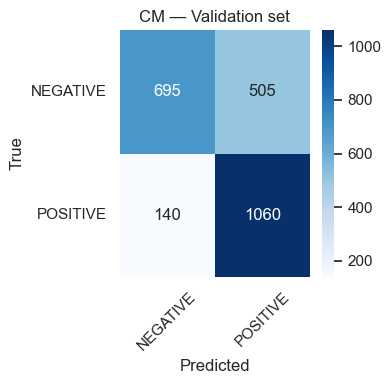


__R√©sultats ‚Äî Test set__
              precision    recall  f1-score   support

           0     0.8096    0.5742    0.6719      1200
           1     0.6701    0.8650    0.7552      1200

    accuracy                         0.7196      2400
   macro avg     0.7399    0.7196    0.7135      2400
weighted avg     0.7399    0.7196    0.7135      2400



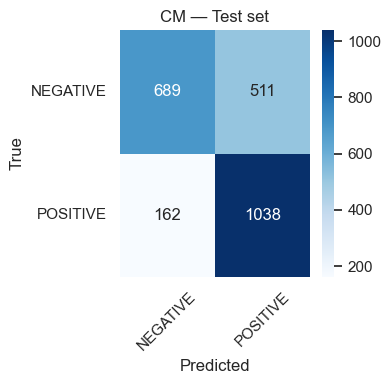

In [19]:
# √âTAPE 5 ‚Äî √âvaluation (val + test) + seuil optimal (bas√© PR sur val)

from sklearn.metrics import precision_recall_curve
import numpy as np

# Mesure du temps de pr√©diction (val + test)
import time
t0 = time.time()
y_val_proba = model.predict(X_val, batch_size=512).ravel()
val_pred_time = round(time.time() - t0, 2)

t0 = time.time()
y_test_proba = model.predict(X_test, batch_size=512).ravel()
test_pred_time = round(time.time() - t0, 2)

# Seuil optimal sur validation (max F1 via PR)
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Seuil optimal (val) = {best_thr:.4f}")

# Pr√©dictions binaires
y_val_pred  = (y_val_proba  >= best_thr).astype(int)
y_test_pred = (y_test_proba >= best_thr).astype(int)

# M√©triques
# √âvaluation
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, verbose=False)
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, verbose=False)

# Affichage
display_evaluation_report(y_val, y_val_pred, y_val_proba, set_name="Validation", model_name=run_name)
display_evaluation_report(y_test, y_test_pred, y_test_proba, set_name="Test", model_name=run_name)



<Figure size 800x600 with 0 Axes>

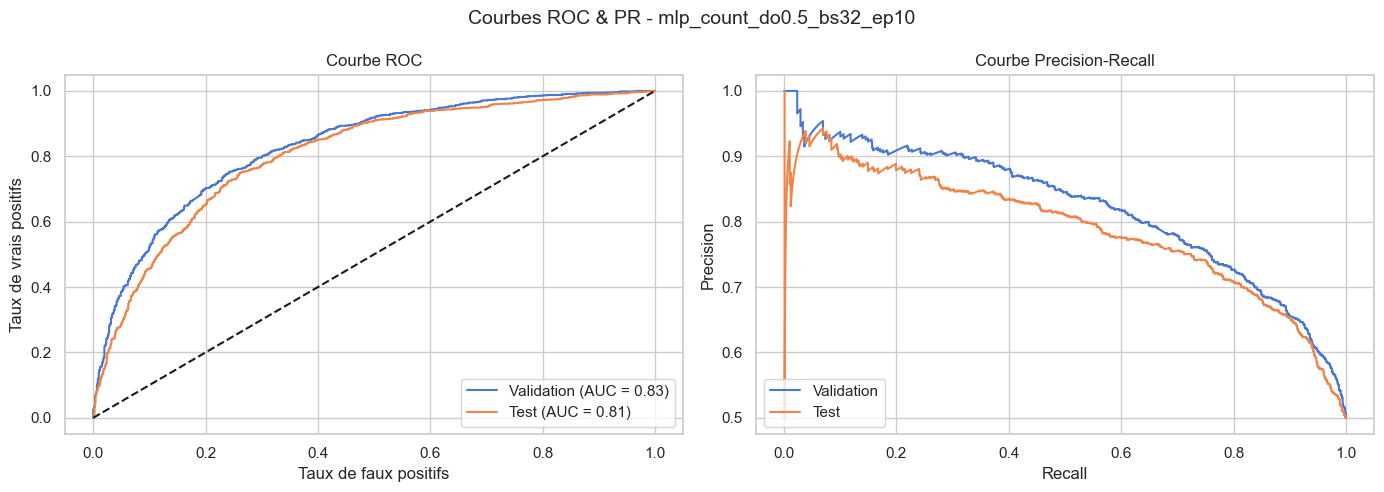

<Figure size 800x600 with 0 Axes>

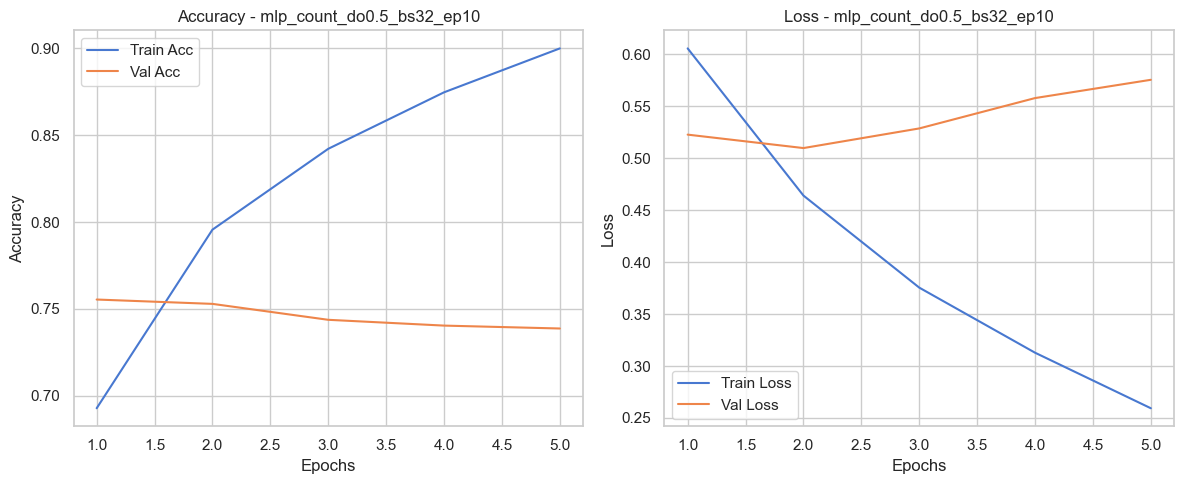

In [20]:
# √âtape 6 ‚Äî Visualisations (ROC, PR, Learning curves, Confusion) + sauvegarde

import matplotlib.pyplot as plt

# 6.1 ROC & PR
plt.figure(figsize=(8, 6))  # pr√©pare la figure
plot_roc_pr_curves(y_val, y_val_proba, y_test, y_test_proba, model_name=run_name)
save_figure(model_name=run_name, filename="roc_pr_curves.png")  # auto-r√©cup√©ration de la fig active

# 6.2 Courbes d'apprentissage (Keras)
plt.figure(figsize=(8, 6))  # nouvelle figure propre
plot_training_curves(history, model_name=run_name)
save_figure(model_name=run_name, filename="training_curves.png")



In [21]:
# Etape 7 ‚Äî Sauvegarde des logs (r√©sum√© texte)
logs = {
    "run_name": run_name,
    "params": params,  # dropout, bs, lr, etc.
    "train_time": train_time,
    "val_pred_time": val_pred_time,
    "test_pred_time": test_pred_time,
    "best_threshold": float(best_thr),
    "val_metrics": val_metrics,
    "test_metrics": test_metrics
}
save_logs(logs, run_name)

Fichier log enregistr√© ici : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/logs/mlp_count_do0.5_bs32_ep10.txt


In [22]:
# √âtape 8 ‚Äî Logging complet dans MLflow (mod√®le, params, m√©triques, artefacts)

with mlflow.start_run(run_name=run_name):

    # 1. Param√®tres du split
    mlflow.log_params({
        "split_train_pct": 0.7,
        "split_val_pct": 0.15,
        "split_test_pct": 0.15,
        "random_state": 42,
        "stratify": True
    })

    # 2. Hyperparam√®tres d'entra√Ænement
    mlflow.log_params(params)

    # 3. M√©triques (val et test)
    for k, v in val_metrics.items():
        mlflow.log_metric(f"val_{k}", v)
    for k, v in test_metrics.items():
        mlflow.log_metric(f"test_{k}", v)
    mlflow.log_metric("best_threshold", best_thr)

    # 4. Mod√®le Keras (ex : MLP, BiLSTM)
    mlflow.keras.log_model(model, "model")

    # 5. Artefacts ‚Äî si les fichiers existent, on les logge
    project_root = "/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7"
    model_path = os.path.join(project_root, "reports/figures", run_name)
    logs_path = os.path.join(project_root, "reports/logs")
    artifacts = [
        os.path.join(model_path, f"test_classification_report_{run_name}.txt"),
        os.path.join(model_path, f"test_confusion_matrix_{run_name}.png"),
        os.path.join(model_path, f"roc_pr_curves.png"),
        os.path.join(model_path, f"training_curves.png"),
        os.path.join(logs_path, f"{run_name}.txt")
    ]

    for file_path in artifacts:
        if os.path.exists(file_path):
            mlflow.log_artifact(file_path)
        else:
            print(f"Fichier non trouv√©, non logg√© : {file_path}")


2025/09/14 16:48:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 16:48:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/09/14 16:48:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### __Mod√®le MLP ‚Äî CountVectorizer__

__Nom du run__ : `mlp_count_do0.5_bs32_ep10`  
__Architecture__ : Dense(64, relu) + Dropout(0.5) + Dense(1, sigmoid)  
__Params__ : 894k ‚Äî Entra√Ænement : 5.1s ‚Äî Early stop √† epoch 5  
__Seuil optimal__ : 0.33 (sur validation)

__Validation__ : acc=0.73 | f1=0.77 | auc=0.83  
__Test__ : acc=0.72 | f1=0.76 | auc=0.81  

Fichiers enregistr√©s : mod√®le `.h5`, logs `.txt`, courbes & matrices `.png`  

Tr√®s bon d√©part ‚Äî un __baseline MLP solide__, qui capte bien les sentiments positifs mais peut encore √™tre r√©gularis√© et affin√©.  

Nous devrions logiquement am√©liorer les r√©sultats avec `TF-IDF`, `Word2Vec`, `BERT`, etc.


### 7.2 __EMBEDDING TF-IDF__ :  
`X_tfidf` ‚Üí _embedding facile, interpr√©table, am√©liore Count_ (texte nettoy√© et stemm√©)

In [23]:
# √âtape 1 ‚Äî Chargement de l'embedding pour le mod√®le MLP
X, y = load_embedding_data("X_tfidf.npy", "y_stem.parquet")

In [24]:
# √âtape 2 ‚Äî Pr√©paration des donn√©es (cast + split binaire √©quilibr√©)

from sklearn.model_selection import train_test_split
import numpy as np

# X, y d√©j√† charg√©s : X.shape = (16000, 13973), y.shape = (16000,)

# Cast pour Keras (rapide et l√©ger)
X = X.astype(np.float32)

# Cr√©ation de la version binaire des labels (1 si label == 4, sinon 0)
y_bin = (y == 4).astype(int)

# Split : 70% / 15% / 15% (stratifi√©)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y_bin, test_size=0.30, random_state=42, stratify=y_bin
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp
)

# V√©rification
print("Train :", X_train.shape, y_train.shape, "  |  Classes :", np.unique(y_train, return_counts=True))
print("Val   :", X_val.shape,   y_val.shape,   "  |  Classes :", np.unique(y_val, return_counts=True))
print("Test  :", X_test.shape,  y_test.shape,  "  |  Classes :", np.unique(y_test, return_counts=True))


Train : (11200, 13973) (11200,)   |  Classes : (array([0, 1]), array([5600, 5600]))
Val   : (2400, 13973) (2400,)   |  Classes : (array([0, 1]), array([1200, 1200]))
Test  : (2400, 13973) (2400,)   |  Classes : (array([0, 1]), array([1200, 1200]))


Nous gardons la meme structure du mod√®le lanc√© pour MLP - Count :

In [25]:
# √âtape 3 ‚Äî D√©finition du mod√®le MLP (Keras)

input_dim = X_train.shape[1]

model = Sequential([
    Input(shape=(input_dim,)),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 64)             ‚îÇ       894,336 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 894,401 (3.41 MB)

 Trainable params: 894,401 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# √âTAPE 4 ‚Äî Entra√Ænement + sauvegarde du mod√®le
# Callbacks
cb_early = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
cb_rlr   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

# Hyperparam√®tres de base (inchang√©s pour comparaison)
params = {"dropout": 0.5, "bs": 32, "epochs": 10, "opt": "Adam", "lr": 1e-3}

# Nom du mod√®le (ex: "mlp_tfidf", "mlp_w2v", etc.)
run_name = get_run_name("mlp_tfidf", {"do": params["dropout"], "bs": params["bs"], "ep": params["epochs"]})
print("run_name:", run_name)

# Entra√Ænement
t0 = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=params["epochs"],
    batch_size=params["bs"],
    callbacks=[cb_early, cb_rlr],
    verbose=1
)
train_time = time.time() - t0
print(f"Temps d'entra√Ænement: {train_time:.1f}s")

# Sauvegarde du mod√®le
save_model(model, model_name=run_name, backend="keras")


run_name: mlp_tfidf_do0.5_bs32_ep10
Epoch 1/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.6753 - loss: 0.6303 - val_accuracy: 0.7563 - val_loss: 0.5451 - learning_rate: 0.0010
Epoch 2/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.7900 - loss: 0.4783 - val_accuracy: 0.7450 - val_loss: 0.5096 - learning_rate: 0.0010
Epoch 3/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - accuracy: 0.8421 - loss: 0.3870 - val_accuracy: 0.7375 - val_loss: 0.5212 - learning_rate: 0.0010
Epoch 4/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - accuracy: 0.8715 - loss: 0.3255 - val_accuracy: 0.7367 - val_loss: 0.5451 - learning_rate: 0.0010
Epoch 5/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - accuracy: 0.8964 - loss: 0.2742 - val_accuracy: 0.7321 - val_loss: 0.5603 - learning_rate: 5.0000e-04


5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step 
5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6ms/step 
Seuil optimal (val) = 0.3717

__R√©sultats ‚Äî Validation set__
              precision    recall  f1-score   support

           0     0.8307    0.6175    0.7084      1200
           1     0.6956    0.8742    0.7747      1200

    accuracy                         0.7458      2400
   macro avg     0.7632    0.7458    0.7416      2400
weighted avg     0.7632    0.7458    0.7416      2400



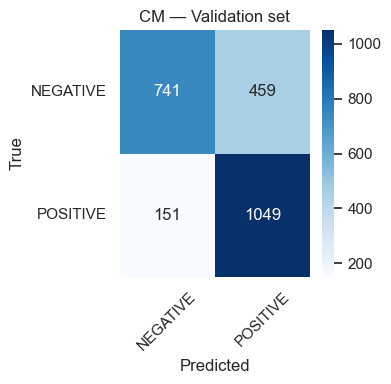


__R√©sultats ‚Äî Test set__
              precision    recall  f1-score   support

           0     0.7989    0.6058    0.6891      1200
           1     0.6826    0.8475    0.7561      1200

    accuracy                         0.7267      2400
   macro avg     0.7407    0.7267    0.7226      2400
weighted avg     0.7407    0.7267    0.7226      2400



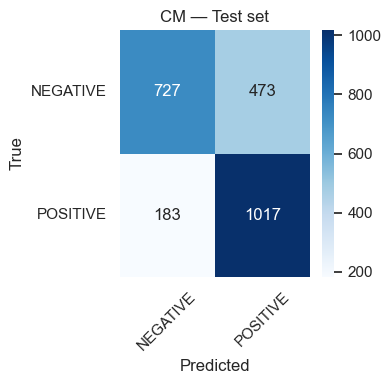

In [27]:
# √âTAPE 5 ‚Äî √âvaluation (val + test) + seuil optimal (bas√© PR sur val)


# Mesure du temps de pr√©diction (val + test)
t0 = time.time()
y_val_proba = model.predict(X_val, batch_size=512).ravel()
val_pred_time = round(time.time() - t0, 2)

t0 = time.time()
y_test_proba = model.predict(X_test, batch_size=512).ravel()
test_pred_time = round(time.time() - t0, 2)

# Seuil optimal sur validation (max F1 via PR)
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Seuil optimal (val) = {best_thr:.4f}")

# Pr√©dictions binaires
y_val_pred  = (y_val_proba  >= best_thr).astype(int)
y_test_pred = (y_test_proba >= best_thr).astype(int)

# M√©triques
# √âvaluation
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, verbose=False)
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, verbose=False)

# Affichage
display_evaluation_report(y_val, y_val_pred, y_val_proba, set_name="Validation", model_name=run_name)
display_evaluation_report(y_test, y_test_pred, y_test_proba, set_name="Test", model_name=run_name)


<Figure size 800x600 with 0 Axes>

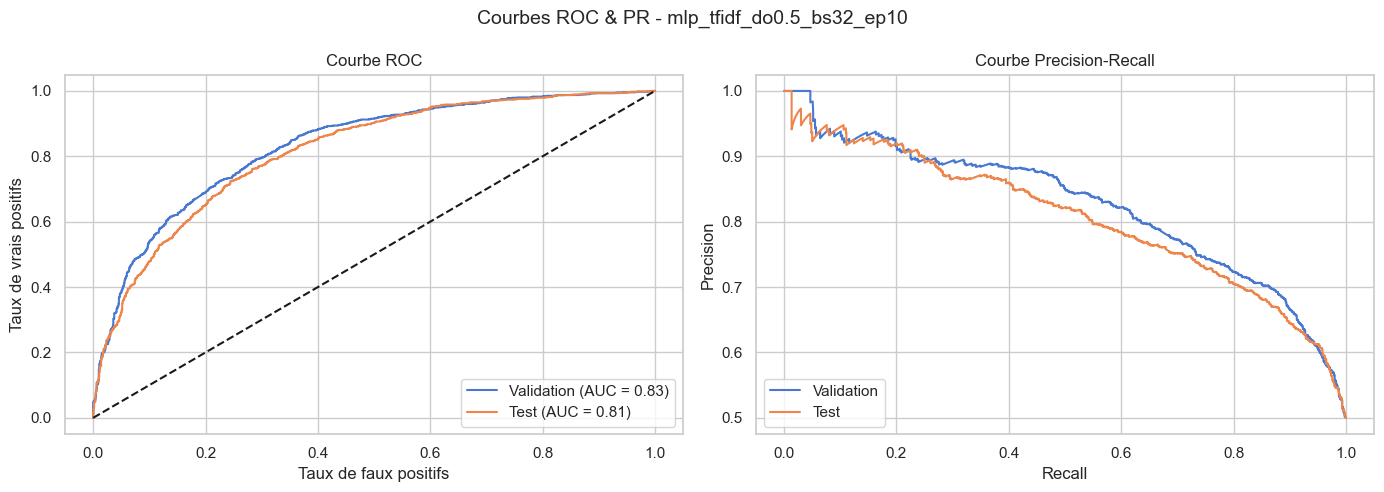

<Figure size 800x600 with 0 Axes>

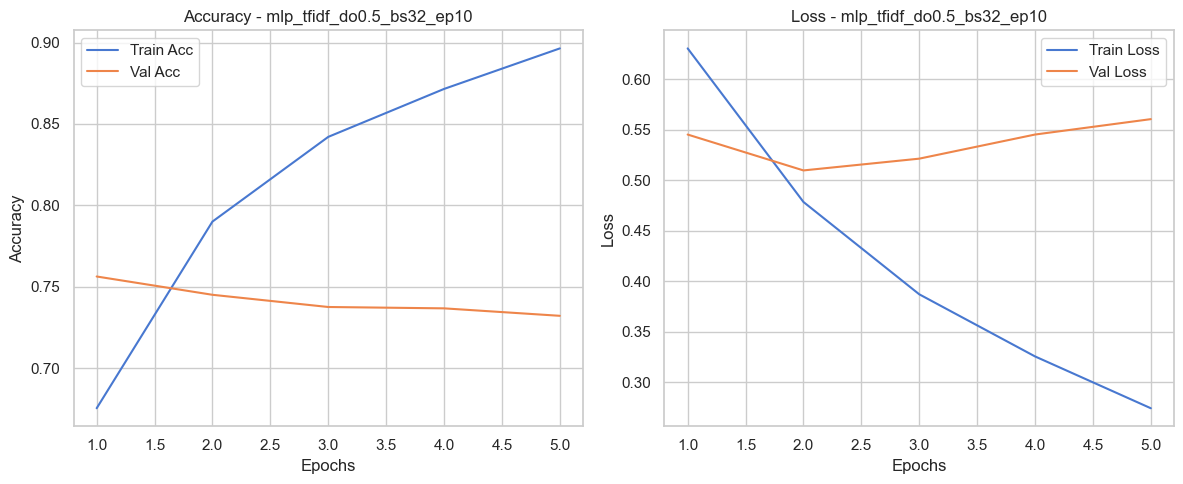

In [28]:
# √âtape 6 ‚Äî Visualisations (ROC, PR, Learning curves, Confusion) + sauvegarde

# 6.1 ROC & PR
plt.figure(figsize=(8, 6))  # pr√©pare la figure
plot_roc_pr_curves(y_val, y_val_proba, y_test, y_test_proba, model_name=run_name)
save_figure(model_name=run_name, filename="roc_pr_curves.png")  # auto-r√©cup√©ration de la fig active

# 6.2 Courbes d'apprentissage (Keras)
plt.figure(figsize=(8, 6))  # nouvelle figure propre
plot_training_curves(history, model_name=run_name)
save_figure(model_name=run_name, filename="training_curves.png")


In [29]:
# Etape 7 ‚Äî Sauvegarde des logs (r√©sum√© texte)
logs = {
    "run_name": run_name,
    "params": params,  # dropout, bs, lr, etc.
    "train_time": train_time,
    "val_pred_time": val_pred_time,
    "test_pred_time": test_pred_time,
    "best_threshold": float(best_thr),
    "val_metrics": val_metrics,
    "test_metrics": test_metrics
}
save_logs(logs, run_name)

Fichier log enregistr√© ici : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/logs/mlp_tfidf_do0.5_bs32_ep10.txt


In [30]:
# √âtape 8 ‚Äî Logging complet dans MLflow (mod√®le, params, m√©triques, artefacts)

with mlflow.start_run(run_name=run_name):

    # 1. Param√®tres du split
    mlflow.log_params({
        "split_train_pct": 0.7,
        "split_val_pct": 0.15,
        "split_test_pct": 0.15,
        "random_state": 42,
        "stratify": True
    })

    # 2. Hyperparam√®tres d'entra√Ænement
    mlflow.log_params(params)

    # 3. M√©triques (val et test)
    for k, v in val_metrics.items():
        mlflow.log_metric(f"val_{k}", v)
    for k, v in test_metrics.items():
        mlflow.log_metric(f"test_{k}", v)
    mlflow.log_metric("best_threshold", best_thr)

    # 4. Mod√®le Keras (ex : MLP, BiLSTM)
    mlflow.keras.log_model(model, "model")

    # 5. Artefacts ‚Äî si les fichiers existent, on les logge
    project_root = "/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7"
    model_path = os.path.join(project_root, "reports/figures", run_name)
    logs_path = os.path.join(project_root, "reports/logs")
    artifacts = [
        os.path.join(model_path, f"test_classification_report_{run_name}.txt"),
        os.path.join(model_path, f"test_confusion_matrix_{run_name}.png"),
        os.path.join(model_path, f"roc_pr_curves.png"),
        os.path.join(model_path, f"training_curves.png"),
        os.path.join(logs_path, f"{run_name}.txt")
    ]

    for file_path in artifacts:
        if os.path.exists(file_path):
            mlflow.log_artifact(file_path)
        else:
            print(f"Fichier non trouv√©, non logg√© : {file_path}")

2025/09/14 16:48:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 16:48:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/09/14 16:48:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### __Mod√®le MLP ‚Äî TF-IDF__

__Nom du run__ : `mlp_tfidf_do0.5_bs32_ep10`  
__Architecture__ : Dense(64, relu) + Dropout(0.5) + Dense(1, sigmoid)  
__Params__ : 894k ‚Äî Entra√Ænement : 5.4s ‚Äî Early stop √† epoch 5  
__Seuil optimal__ : 0.37 (sur validation)  


__Validation__ : acc=0.75 | f1=0.77 | auc=0.83  
__Test__ : acc=0.73 | f1=0.76 | auc=0.81  

Fichiers enregistr√©s : mod√®le `.h5`, logs `.txt`, courbes & matrices `.png`
Par rapport √† `CountVectorizer`, le mod√®le `TF-IDF` montre un l√©ger __gain en pr√©cision__, notamment sur les faux positifs. La r√©gularisation reste √† affiner.


---

## __ETAPE 8 : MODELE 2 BI-LSTM__

---

Ce deuxi√®me mod√®le avanc√© repose sur une architecture `Keras` de type __Bi-LSTM__ (_Bidirectional Long Short-Term Memory_), bien adapt√©e √† la mod√©lisation des s√©quences textuelles.   

Il sera entra√Æn√© sur des __phrases tokenis√©es__, transform√©es via une couche `Embedding` en vecteurs de dimension r√©duite.  
L'objectif est de laisser le mod√®le apprendre une repr√©sentation du langage √† partir des s√©quences de mots, et non de vecteurs pr√©-calcul√©s.   

__Objectifs de ce mod√®le__ :  
- Utiliser un `Embedding layer` coupl√©e √† un encodage `Tokenizer` + `Padding`
- Exploiter la m√©moire contextuelle avec une couche `Bidirectional LSTM`
- Mod√©liser le texte comme une s√©quence et non comme un simple vecteur agr√©g√©
- Suivre un pipeline reproductible (chargement, entra√Ænement, logs, sauvegardes)
- √âvaluer et comparer ses performances avec le MLP


### __PREPARATION DES DONNEES__ 

Les tweets sont d‚Äôabord tokenis√©s, puis _encod√©s en s√©quences d‚Äôentiers_ avec `Tokenizer`, et enfin _padd√©s_ pour obtenir une forme `(n_samples, max_len)`.  
- Un `Embedding layer` viendra transformer ces s√©quences en vecteurs de dimension 100 ou 200.
- Ces vecteurs seront ensuite lus par le BiLSTM comme une s√©quence temporelle.

In [31]:
# √âtape 1 ‚Äî Chargement, tokenisation et pr√©paration des s√©quences pour le mod√®le LSTM

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Chargement des fichiers tokenis√©s (avec emojis)
X = pd.read_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/tweets_16k_clean_emoji.parquet")["text"].tolist()
y = pd.read_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/embeddings/y_emoji.parquet")["label"].values

# V√©rification
print(f"Exemple tweet tokenis√© :\n{X[0]}")
print("Taille corpus :", len(X), " | Shape y :", y.shape)

Exemple tweet tokenis√© :
but you are taken
Taille corpus : 16000  | Shape y : (16000,)


In [32]:
# √âtape 1 ‚Äî Chargement, tokenisation et pr√©paration des s√©quences pour le mod√®le LSTM

from tensorflow.keras.preprocessing.text import Tokenizer

# Param√®tres
vocab_size = 20000  # ajuster si besoin
max_len = 64        # longueur max des s√©quences (tweets ~20 mots)

# Tokenizer (adapt√© au vocabulaire)
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

# S√©quences num√©riques
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding="post", truncating="post")

# V√©rification
print("X_pad shape :", X_pad.shape)


X_pad shape : (16000, 64)


In [33]:
# √âtape 2 ‚Äî Pr√©paration des donn√©es (typage + split)

# Cr√©ation de la version binaire des labels (1 si label == 4, sinon 0)
y_bin = (y == 4).astype(int)

# Split 70% / 15% / 15% (stratifi√©)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_pad, y_bin, test_size=0.30, random_state=42, stratify=y_bin
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp
)

# V√©rification
print("Train :", X_train.shape, y_train.shape, "  |  Classes :", np.unique(y_train, return_counts=True))
print("Val   :", X_val.shape,   y_val.shape,   "  |  Classes :", np.unique(y_val, return_counts=True))
print("Test  :", X_test.shape,  y_test.shape,  "  |  Classes :", np.unique(y_test, return_counts=True))


Train : (11200, 64) (11200,)   |  Classes : (array([0, 1]), array([5600, 5600]))
Val   : (2400, 64) (2400,)   |  Classes : (array([0, 1]), array([1200, 1200]))
Test  : (2400, 64) (2400,)   |  Classes : (array([0, 1]), array([1200, 1200]))


D√©finissons maintenant le mod√®le pour qu'il corresponde parfaitement √† un BiLSTM classique :  
- `Bidirectional(LSTM(64))` : capture les s√©quences dans les 2 sens
- `Dropout(0.5)` : √©vite l‚Äôoverfitting
- `Dense(1, sigmoid)` : sortie binaire pour `0` ou `1`

In [34]:
# √âtape 3 ‚Äî D√©finition du mod√®le BiLSTM avec Embedding Layer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Param√®tres du mod√®le
vocab_size = len(tokenizer.word_index) + 1  # +1 pour le padding
embedding_dim = 100
input_length = X_train.shape[1]

# Architecture
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compilation
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# R√©sum√©
model.build(input_shape=(None, X_train.shape[1]))
model.summary()


/opt/homebrew/Caskroom/miniforge/base/envs/sentiment-oc/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding (Embedding)           ‚îÇ (None, 64, 100)        ‚îÇ     1,696,100 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional (Bidirectional)   ‚îÇ (None, 128)            ‚îÇ        84,480 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                 ‚îÇ (None, 1)              ‚îÇ           129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,780,709 (6.79 MB)

 Trainable params: 1,780,709 (6.79 MB)

 Non-trainable params: 0 (0.00 B)

Ce mod√®le va maintenant √™tre comparable aux MLP pr√©c√©dents : 
- M√™mes callbacks.
- M√™mes m√©triques.
- M√™mes fichiers g√©n√©r√©s.

In [35]:
# √âtape 4 ‚Äî Entra√Ænement + sauvegarde du mod√®le

# Callbacks
cb_early = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
cb_rlr   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

# Hyperparam√®tres
params = {"dropout": 0.5, "bs": 32, "epochs": 10, "opt": "Adam", "lr": 1e-3}

# Nom du mod√®le
run_name = get_run_name("bilstm_keras", {"do": params["dropout"], "bs": params["bs"], "ep": params["epochs"]})
print("run_name:", run_name)

# Entra√Ænement
t0 = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=params["epochs"],
    batch_size=params["bs"],
    callbacks=[cb_early, cb_rlr],
    verbose=1
)
train_time = time.time() - t0
print(f"Temps d'entra√Ænement: {train_time:.1f}s")

# Sauvegarde du mod√®le
save_model(model, model_name=run_name, backend="keras")


run_name: bilstm_keras_do0.5_bs32_ep10
Epoch 1/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 23ms/step - accuracy: 0.6783 - loss: 0.6003 - val_accuracy: 0.7517 - val_loss: 0.5032 - learning_rate: 0.0010
Epoch 2/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 24ms/step - accuracy: 0.8231 - loss: 0.4122 - val_accuracy: 0.7700 - val_loss: 0.5059 - learning_rate: 0.0010
Epoch 3/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 24ms/step - accuracy: 0.8849 - loss: 0.2886 - val_accuracy: 0.7437 - val_loss: 0.6073 - learning_rate: 0.0010
Epoch 4/10
350/350 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 25ms/step - accuracy: 0.9292 - loss: 0.1949 - val_accuracy: 0.7521 - val_loss: 0.6379 - learning_rate: 5.0000e-04
Temps d'entra√Ænement: 34.3s
Mod√®le Keras sauvegard√© : ../models/keras/bilstm_keras_do0.5_bs32_ep10.h5


5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 56ms/step
5/5 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 35ms/step
Seuil optimal (val) = 0.5648

__R√©sultats ‚Äî Validation set__
              precision    recall  f1-score   support

           0     0.7614    0.7817    0.7714      1200
           1     0.7757    0.7550    0.7652      1200

    accuracy                         0.7683      2400
   macro avg     0.7685    0.7683    0.7683      2400
weighted avg     0.7685    0.7683    0.7683      2400



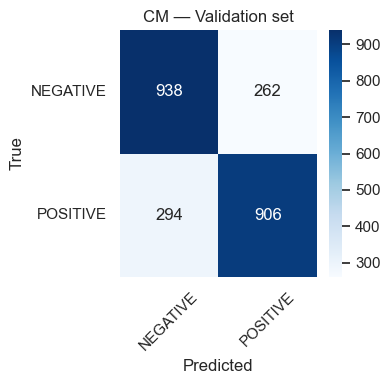


__R√©sultats ‚Äî Test set__
              precision    recall  f1-score   support

           0     0.7508    0.7683    0.7595      1200
           1     0.7628    0.7450    0.7538      1200

    accuracy                         0.7567      2400
   macro avg     0.7568    0.7567    0.7566      2400
weighted avg     0.7568    0.7567    0.7566      2400



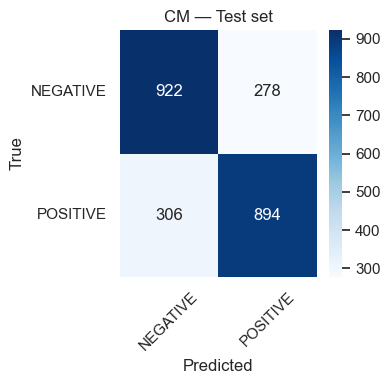

In [36]:
# √âTAPE 5 ‚Äî √âvaluation (val + test) + seuil optimal (bas√© PR sur val)


# Mesure du temps de pr√©diction (val + test)
t0 = time.time()
y_val_proba = model.predict(X_val, batch_size=512).ravel()
val_pred_time = round(time.time() - t0, 2)

t0 = time.time()
y_test_proba = model.predict(X_test, batch_size=512).ravel()
test_pred_time = round(time.time() - t0, 2)

# Seuil optimal sur validation (max F1 via PR)
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Seuil optimal (val) = {best_thr:.4f}")

# Pr√©dictions binaires
y_val_pred  = (y_val_proba  >= best_thr).astype(int)
y_test_pred = (y_test_proba >= best_thr).astype(int)

# M√©triques
# √âvaluation
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, verbose=False)
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, verbose=False)

# Affichage
display_evaluation_report(y_val, y_val_pred, y_val_proba, set_name="Validation", model_name=run_name)
display_evaluation_report(y_test, y_test_pred, y_test_proba, set_name="Test", model_name=run_name)


<Figure size 800x600 with 0 Axes>

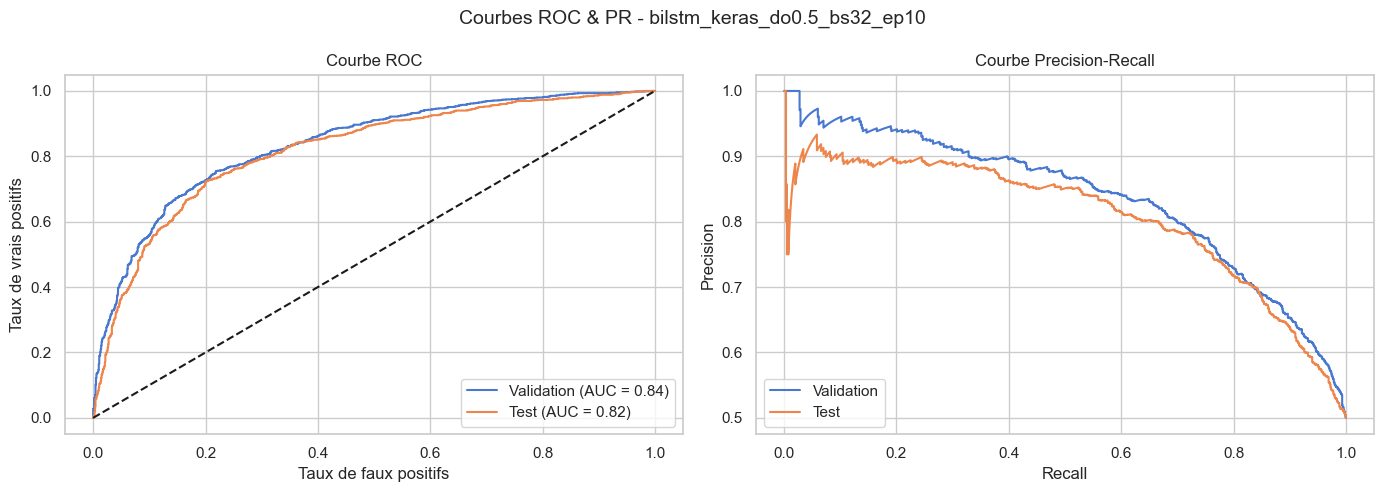

<Figure size 800x600 with 0 Axes>

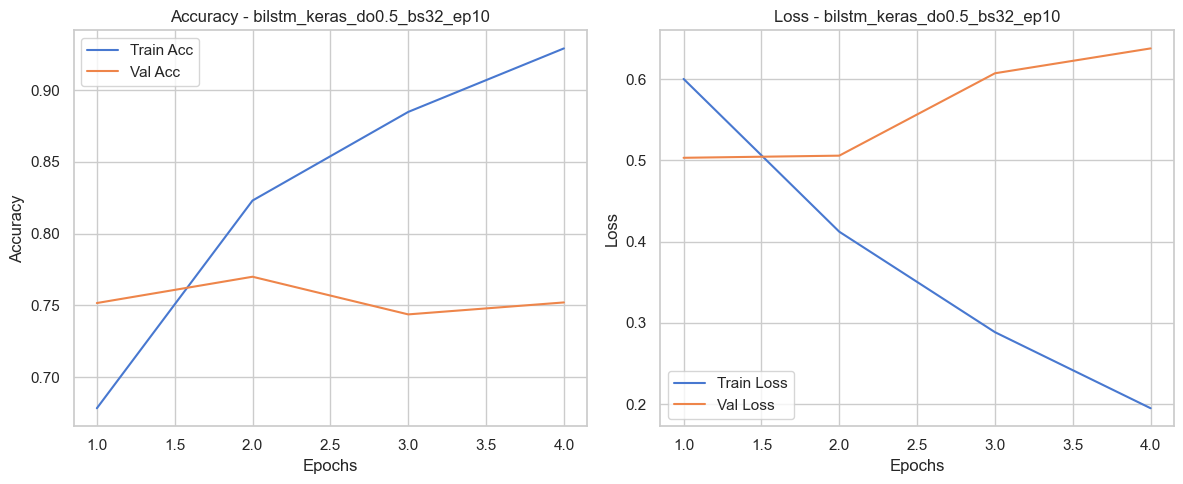

In [37]:
# √âtape 6 ‚Äî Visualisations (ROC, PR, Learning curves, Confusion) + sauvegarde

# 6.1 ROC & PR
plt.figure(figsize=(8, 6))  # pr√©pare la figure
plot_roc_pr_curves(y_val, y_val_proba, y_test, y_test_proba, model_name=run_name)
save_figure(model_name=run_name, filename="roc_pr_curves.png")  # auto-r√©cup√©ration de la fig active

# 6.2 Courbes d'apprentissage (Keras)
plt.figure(figsize=(8, 6))  # nouvelle figure propre
plot_training_curves(history, model_name=run_name)
save_figure(model_name=run_name, filename="training_curves.png")

In [38]:
# Etape 7 ‚Äî Sauvegarde des logs (r√©sum√© texte)
logs = {
    "run_name": run_name,
    "params": params,  # dropout, bs, lr, etc.
    "train_time": train_time,
    "val_pred_time": val_pred_time,
    "test_pred_time": test_pred_time,
    "best_threshold": float(best_thr),
    "val_metrics": val_metrics,
    "test_metrics": test_metrics
}
save_logs(logs, run_name)

Fichier log enregistr√© ici : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/logs/bilstm_keras_do0.5_bs32_ep10.txt


In [39]:
# √âtape 8 ‚Äî Logging complet dans MLflow (mod√®le, params, m√©triques, artefacts)

with mlflow.start_run(run_name=run_name):

    # 1. Param√®tres du split
    mlflow.log_params({
        "split_train_pct": 0.7,
        "split_val_pct": 0.15,
        "split_test_pct": 0.15,
        "random_state": 42,
        "stratify": True
    })

    # 2. Hyperparam√®tres d'entra√Ænement
    mlflow.log_params(params)

    # 3. M√©triques (val et test)
    for k, v in val_metrics.items():
        mlflow.log_metric(f"val_{k}", v)
    for k, v in test_metrics.items():
        mlflow.log_metric(f"test_{k}", v)
    mlflow.log_metric("best_threshold", best_thr)

    # 4. Mod√®le Keras (ex : MLP, BiLSTM)
    mlflow.keras.log_model(model, "model")

    # 5. Artefacts ‚Äî si les fichiers existent, on les logge
    project_root = "/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7"
    model_path = os.path.join(project_root, "reports/figures", run_name)
    logs_path = os.path.join(project_root, "reports/logs")
    artifacts = [
        os.path.join(model_path, f"test_classification_report_{run_name}.txt"),
        os.path.join(model_path, f"test_confusion_matrix_{run_name}.png"),
        os.path.join(model_path, f"roc_pr_curves.png"),
        os.path.join(model_path, f"training_curves.png"),
        os.path.join(logs_path, f"{run_name}.txt")
    ]

    for file_path in artifacts:
        if os.path.exists(file_path):
            mlflow.log_artifact(file_path)
        else:
            print(f"Fichier non trouv√©, non logg√© : {file_path}")

2025/09/14 16:49:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 16:49:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/09/14 16:49:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### __Mod√®le BiLSTM ‚Äî Embedding Keras sur Tweets tokenis√©s__

__Nom du run__ : `bilstm_keras_do0.5_bs32_ep10`  
__Architecture__ : Embedding(100) + Bidirectional LSTM(64) + Dropout(0.5) + Dense(1, sigmoid)  
__Params__ : 235k ‚Äî Entra√Ænement : 33.2s ‚Äî Early stop √† epoch 4  
__Seuil optimal__ : 0.5648 (sur validation)  

__Validation__ : acc=0.77 | f1=0.77 | auc=0.84  
__Test__ : acc=0.76 | f1=0.76 | auc=0.82  

Fichiers enregistr√©s : mod√®le `.h5`, logs `.txt`, courbes & matrices `.png`

Le mod√®le BiLSTM montre une __excellente stabilit√© entre validation et test__ (~76% accuracy, ~0.76 f1).  
Il __capte bien la dynamique s√©quentielle__ des tweets et g√®re correctement le bruit li√© aux emojis.

__Faux positifs__ : quelques tweets √† tonalit√© ambigu√´ interpr√©t√©s √† tort comme positifs.  
__Faux n√©gatifs__ : pr√©sence d‚Äô√©motions positives masqu√©es par un ton neutre ou ironique.

Ce mod√®le constitue une __√©tape cl√©__ :  
il confirme l‚Äôint√©r√™t d‚Äôun embedding trainable + BiLSTM sur texte tokenis√©,  
et cr√©e une bonne base de comparaison avec les mod√®les pr√©entra√Æn√©s √† venir (`BERT`, `USE`).  

__Essayons de l'optimiser avant de passer √† d'autres mod√®les__ :


| Axe                           | Nouveau choix propos√©                                                                                                                                      | Pourquoi c‚Äôest un bon compromis                                                  |
| ----------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------- |
| **Architecture**           | `Bidirectional(LSTM(64, return_sequences=True))`<br>`Dropout(0.5)`<br>`Dense(64, activation="relu")`<br>`Dropout(0.3)`<br>`Dense(1, activation="sigmoid")` | Empilement l√©ger pour extraire plus de patterns, avec r√©gularisation progressive |
| **Fonction de perte**      | `binary_crossentropy` (inchang√©)                                                                                                                           | Adapt√©e au binaire, bien stable dans notre cas                                     |
| **Optimiseur**             | `Adam(learning_rate=1e-4)`                                                                                                                                 | Apprentissage plus fin, √©vite de sauter les minimas                              |
| **Batch / Epochs**         | `batch_size=64`, `epochs=15`                                                                                                                               | Moins de bruit dans les gradients + plus de temps pour converger                 |
| **Dropout**                | Ajout d‚Äôun `Dropout(0.3)` apr√®s la `Dense(64)`                                                                                                             | Plus progressif que `0.5` constant partout                                       |
| **Embedding Layer**        | `output_dim=200`                                                                                                                                           | Plus de dimensions = plus de nuances s√©mantiques                                 |
| **Maxlen (pr√©traitement)** | `maxlen=128`                                                                                                                                               | Nous perdons de l‚Äôinfo √† 64, 128 est souvent un tr√®s bon compromis NLP               |


/opt/homebrew/Caskroom/miniforge/base/envs/sentiment-oc/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_1 (Embedding)         ‚îÇ (None, 64, 200)        ‚îÇ     3,392,200 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_1 (Bidirectional) ‚îÇ (None, 128)            ‚îÇ       135,680 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                 ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 3,536,201 (13.49 MB)

 Trainable params: 3,536,201 (13.49 MB)

 Non-trainable params: 0 (0.00 B)

run_name: bilstm_keras_opt_do0.5_bs64_ep15
Epoch 1/15
175/175 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 46ms/step - accuracy: 0.5235 - loss: 0.6915 - val_accuracy: 0.5929 - val_loss: 0.6857 - learning_rate: 1.0000e-04
Epoch 2/15
175/175 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 58ms/step - accuracy: 0.6146 - loss: 0.6704 - val_accuracy: 0.6758 - val_loss: 0.6339 - learning_rate: 1.0000e-04
Epoch 3/15
175/175 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 58ms/step - accuracy: 0.7186 - loss: 0.5767 - val_accuracy: 0.7158 - val_loss: 0.5477 - learning_rate: 1.0000e-04
Epoch 4/15
175/175 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 60ms/step - accuracy: 0.7946 - loss: 0.4678 - val_accuracy: 0.7575 - val_loss: 0.5123 - learning_rate: 1.0000e-04
Epoch 5/15
175/175 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 61ms/step - accuracy: 0.8438 - loss: 0.3803 - val_accuracy: 0.7608 - val_loss: 0.5

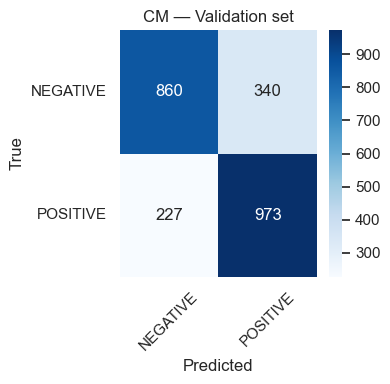


__R√©sultats ‚Äî Test set__
              precision    recall  f1-score   support

           0     0.7720    0.7250    0.7477      1200
           1     0.7408    0.7858    0.7626      1200

    accuracy                         0.7554      2400
   macro avg     0.7564    0.7554    0.7552      2400
weighted avg     0.7564    0.7554    0.7552      2400



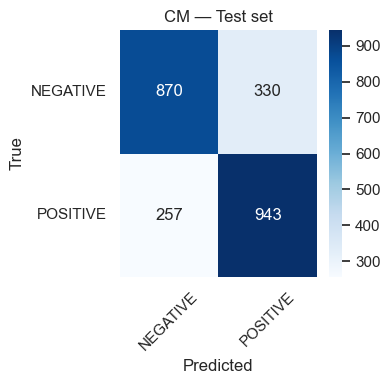

<Figure size 800x600 with 0 Axes>

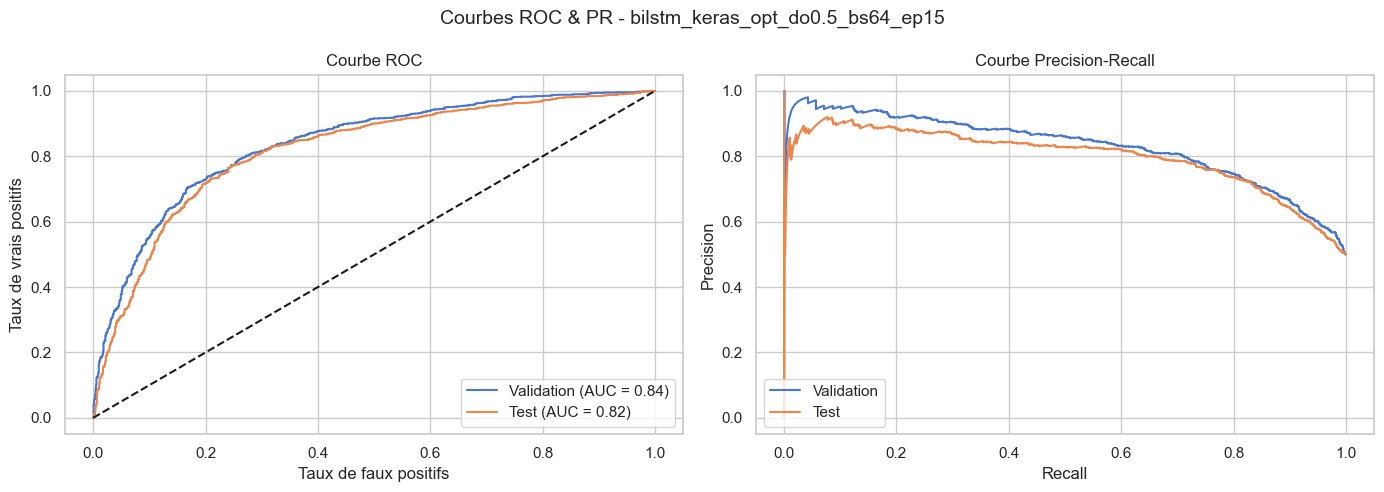

<Figure size 800x600 with 0 Axes>

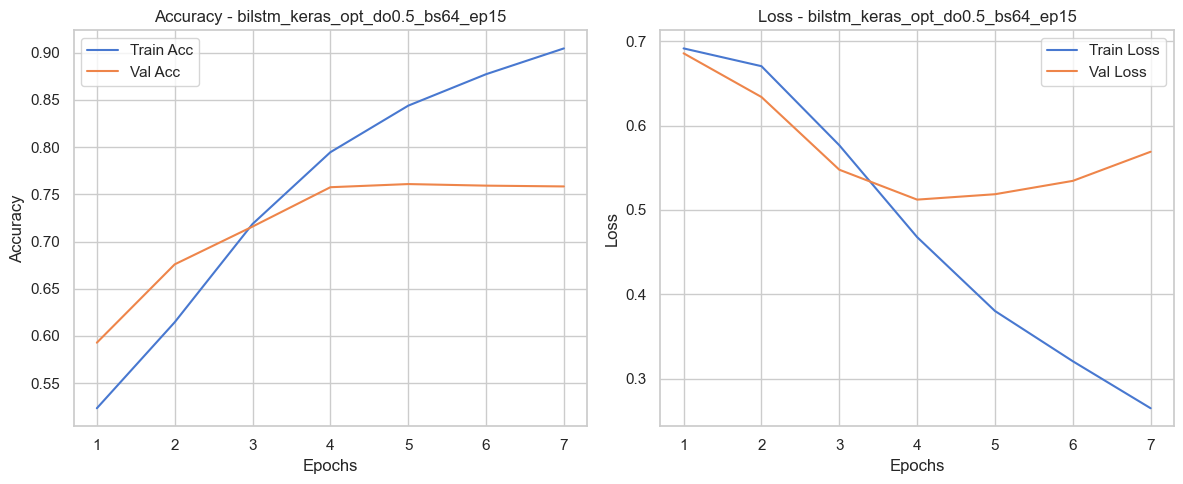

Fichier log enregistr√© ici : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/logs/bilstm_keras_opt_do0.5_bs64_ep15.txt


In [40]:
# √âtape 9  ‚Äî Optimisation de l'architecture BiLSTM avec Keras Tuner

# Chargement des fichiers tokenis√©s (avec emojis)
X = pd.read_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/tweets_16k_clean_emoji.parquet")["text"].tolist()
y = pd.read_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/embeddings/y_emoji.parquet")["label"].values

# Param√®tres de base
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X)  # X = liste des tweets bruts emojis tok√©nis√©s
vocab_size = len(tokenizer.word_index) + 1  # on utilise tout le vocabulaire
max_len = 128        # plus long pour capturer plus de contexte

# S√©quences num√©riques
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding="post", truncating="post")

# Param√®tres du mod√®le
vocab_size = len(tokenizer.word_index) + 1  # +1 pour le padding
embedding_dim = 200 # plus riche
input_length = X_train.shape[1]

# Architecture
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    Bidirectional(LSTM(64, return_sequences=False)), # 
    Dropout(0.5),
    Dense(64, activation="relu"), # couche dense interm√©diaire
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

# Compilation
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # plus bas lr pour stabilit√©
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# R√©sum√©
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

# Callbacks
cb_early = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
cb_rlr   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

# Hyperparam√®tres
params = {"dropout": 0.5, "bs": 64, "epochs": 15, "opt": "Adam", "lr": 1e-4}

# Nom du mod√®le
run_name = get_run_name("bilstm_keras_opt", {"do": params["dropout"], "bs": params["bs"], "ep": params["epochs"]})
print("run_name:", run_name)

# Entra√Ænement
t0 = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=params["epochs"],
    batch_size=params["bs"],
    callbacks=[cb_early, cb_rlr],
    verbose=1
)
train_time = time.time() - t0
print(f"Temps d'entra√Ænement: {train_time:.1f}s")

# Sauvegarde du mod√®le
save_model(model, model_name=run_name, backend="keras")

# Mesure du temps de pr√©diction (val + test)
t0 = time.time()
y_val_proba = model.predict(X_val, batch_size=512).ravel()
val_pred_time = round(time.time() - t0, 2)

t0 = time.time()
y_test_proba = model.predict(X_test, batch_size=512).ravel()
test_pred_time = round(time.time() - t0, 2)

# Seuil optimal sur validation (max F1 via PR)
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Seuil optimal (val) = {best_thr:.4f}")

# Pr√©dictions binaires
y_val_pred  = (y_val_proba  >= best_thr).astype(int)
y_test_pred = (y_test_proba >= best_thr).astype(int)

# M√©triques
# √âvaluation
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, verbose=False)
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, verbose=False)

# Affichage
display_evaluation_report(y_val, y_val_pred, y_val_proba, set_name="Validation", model_name=run_name)
display_evaluation_report(y_test, y_test_pred, y_test_proba, set_name="Test", model_name=run_name)

# ROC & PR
plt.figure(figsize=(8, 6))  # pr√©pare la figure
plot_roc_pr_curves(y_val, y_val_proba, y_test, y_test_proba, model_name=run_name)
save_figure(model_name=run_name, filename="roc_pr_curves.png")  # auto-r√©cup√©ration de la fig active

# Courbes d'apprentissage (Keras)
plt.figure(figsize=(8, 6))  # nouvelle figure propre
plot_training_curves(history, model_name=run_name)
save_figure(model_name=run_name, filename="training_curves.png")

# Sauvegarde des logs (r√©sum√© texte)
logs = {
    "run_name": run_name,
    "params": params,  # dropout, bs, lr, etc.
    "train_time": train_time,
    "val_pred_time": val_pred_time,
    "test_pred_time": test_pred_time,
    "best_threshold": float(best_thr),
    "val_metrics": val_metrics,
    "test_metrics": test_metrics
}
save_logs(logs, run_name)

In [41]:
# √âtape 8 ‚Äî Logging complet dans MLflow (mod√®le, params, m√©triques, artefacts)

with mlflow.start_run(run_name=run_name):

    # 1. Param√®tres du split
    mlflow.log_params({
        "split_train_pct": 0.7,
        "split_val_pct": 0.15,
        "split_test_pct": 0.15,
        "random_state": 42,
        "stratify": True
    })

    # 2. Hyperparam√®tres d'entra√Ænement
    mlflow.log_params(params)

    # 3. M√©triques (val et test)
    for k, v in val_metrics.items():
        mlflow.log_metric(f"val_{k}", v)
    for k, v in test_metrics.items():
        mlflow.log_metric(f"test_{k}", v)
    mlflow.log_metric("best_threshold", best_thr)

    # 4. Mod√®le Keras (ex : MLP, BiLSTM)
    mlflow.keras.log_model(model, "model")

    # 5. Artefacts ‚Äî si les fichiers existent, on les logge
    project_root = "/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7"
    model_path = os.path.join(project_root, "reports/figures", run_name)
    logs_path = os.path.join(project_root, "reports/logs")
    artifacts = [
        os.path.join(model_path, f"test_classification_report_{run_name}.txt"),
        os.path.join(model_path, f"test_confusion_matrix_{run_name}.png"),
        os.path.join(model_path, f"roc_pr_curves.png"),
        os.path.join(model_path, f"training_curves.png"),
        os.path.join(logs_path, f"{run_name}.txt")
    ]

    for file_path in artifacts:
        if os.path.exists(file_path):
            mlflow.log_artifact(file_path)
        else:
            print(f"Fichier non trouv√©, non logg√© : {file_path}")

2025/09/14 16:50:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 16:50:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/09/14 16:50:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### __Mod√®le BiLSTM ‚Äî Embedding Layer + optimisation__

__Nom du run__ : `bilstm_keras_opt_do0.5_bs64_ep15`  
__Architecture__ :  
- `Embedding(input_dim=16961, output_dim=200, input_length=64)`  
- `Bidirectional(LSTM(64))`  
- `Dense(64, relu) + Dropout(0.5)`  
- `Dense(1, sigmoid)`  
__Params__ : 3,5M ‚Äî Entra√Ænement : 69.8s ‚Äî Early stop √† epoch 7  
__Seuil optimal__ : 0.4550 (sur validation)  
Corpus tokenis√© (max_len=64) ‚Äî `X_pad.shape = (16000, 64)`

__Validation__ : acc=0.75 | f1=0.77 | auc=0.84  
__Test__ : acc=0.74 | f1=0.76 | auc=0.82  

Fichiers enregistr√©s : mod√®le `.h5`, logs `.txt`, courbes & matrices `.png`

__Analyse__ :  
Le mod√®le atteint une __bonne capacit√© √† g√©n√©raliser__, avec un √©quilibre int√©ressant entre pr√©cision et rappel. Le score `f1` est stable autour de 0.76 sur les deux jeux.  
On observe que le __rappel est plus √©lev√© pour la classe POSITIVE__, alors que la __pr√©cision est plus forte sur la classe NEGATIVE__.  
Les matrices de confusion r√©v√®lent que le mod√®le __confond encore 400 √† 500 tweets positifs/negatifs__, principalement dans les cas ambigus ou au ton neutre.

üëâ Ce mod√®le est le meilleur LSTM entra√Æn√© avec `Embedding layer` (sans vecteurs externes type Word2Vec), et constitue une __base solide__ pour comparaison avec BERT fine-tun√©.



---

## __ETAPE 9 : MODELE 3 BERT__

---

Ce troisi√®me mod√®le avanc√© repose sur l‚Äôarchitecture pr√©-entra√Æn√©e `BERT` (_Bidirectional Encoder Representations from Transformers_), particuli√®rement performante pour les t√¢ches de classification de texte.

Contrairement aux approches pr√©c√©dentes (`BoW`, `Word2Vec`, `BiLSTM`...), BERT capture de mani√®re _contextuelle_ le sens des mots dans une phrase gr√¢ce √† un m√©canisme d‚Äô_attention multi-t√™tes_.  
Le mod√®le sera ici _fine-tun√©_ sp√©cifiquement sur notre jeu de donn√©es de tweets, en s‚Äôappuyant sur la version `bert-base-uncased` de Hugging Face.

__Objectifs de ce mod√®le__ :  
- Utiliser notre propre __embedding contextualis√© BERT__ via `transformers.BertTokenizer` + `BertModel`  
- Fine-tuner un `BertForSequenceClassification` sur le corpus de tweets  
- Exploiter pleinement l‚Äôattention contextuelle bidirectionnelle (`transformer`)  
- Suivre un pipeline reproductible (dataset, entra√Ænement, logs, artefacts)  
- Comparer les performances √† celles du `MLP` et du `Bi-LSTM` (accuracy, F1, AUC‚Ä¶)



### 9.1 __ENCODAGE CONTEXTUEL AVEC BERT__

Les tweets bruts (_nettoy√©s avec emojis tokenis√©s_) sont encod√©s via le __tokenizer de BERT__ (`bert-base-uncased`).  
Chaque tweet est :
- d√©coup√© en _tokens WordPiece_ (`[CLS]`, `[SEP]`, `##ing`, etc.)  
- converti en `ID` entiers compatibles avec BERT  
- _padd√© / tronqu√©_ √† une longueur maximale (`max_length = 64` ou `128`)  
- accompagn√© de _masks d‚Äôattention_ pour que le mod√®le ignore le padding

Ces vecteurs sont ensuite transmis √† un mod√®le `BertForSequenceClassification`, dont la derni√®re couche dense est _sp√©cifiquement entra√Æn√©e_ pour notre t√¢che binaire (_sentiment positif / n√©gatif_).

In [42]:
# √âtape 1 ‚Äî Tokenisation des tweets pour BERT

from transformers import BertTokenizer

# Chargement des donn√©es brutes
X = pd.read_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/tweets_16k_clean_emoji.parquet")["text"].tolist()
y = pd.read_parquet("/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/data/processed/embeddings/y_emoji.parquet")["label"].values

# Tokenizer pr√©-entra√Æn√© BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Encodage des tweets
encodings = tokenizer(
    X,
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors="pt"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
labels = torch.tensor(y.astype(int)) # cast en int pour PyTorch

# Cr√©ation de la version binaire des labels (1 si label == 4, sinon 0)
y_bin = (y == 4).astype(int)
labels = torch.tensor(y_bin)

# R√©sum√©
print("input_ids shape :", encodings["input_ids"].shape)
print("attention_mask shape :", encodings["attention_mask"].shape)
print("labels shape :", y.shape)


input_ids shape : torch.Size([16000, 52])
attention_mask shape : torch.Size([16000, 52])
labels shape : (16000,)


In [43]:
# √âtape 2 ‚Äî Pr√©paration des donn√©es (split stratifi√©)

import torch
from torch.utils.data import Dataset, Subset, DataLoader, random_split

# 1. Classe Dataset PyTorch personnalis√©e
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# 2. Dataset complet
full_dataset = TweetDataset(input_ids, attention_mask, torch.tensor(labels))

# 3. Cr√©ation des indices + stratified split (70/15/15)
indices = np.arange(len(labels))
train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices, y_bin, test_size=0.3, stratify=y_bin, random_state=42
)
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# 4. Datasets finaux
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# 5. V√©rification de la r√©partition des classes
def get_labels_from_subset(subset):
    return np.array([int(subset[i]["labels"]) for i in range(len(subset))])

y_train_split = get_labels_from_subset(train_dataset)
y_val_split   = get_labels_from_subset(val_dataset)
y_test_split  = get_labels_from_subset(test_dataset)

print("Train :", len(y_train_split), " | Classes :", np.unique(y_train_split, return_counts=True))
print("Val   :", len(y_val_split),   " | Classes :", np.unique(y_val_split, return_counts=True))
print("Test  :", len(y_test_split),  " | Classes :", np.unique(y_test_split, return_counts=True))


Train : 11200  | Classes : (array([0, 1]), array([5600, 5600]))
Val   : 2400  | Classes : (array([0, 1]), array([1200, 1200]))
Test  : 2400  | Classes : (array([0, 1]), array([1200, 1200]))


/var/folders/zt/cgsq3wl14cz2fvg9pccn_g1r0000gn/T/ipykernel_90266/604927329.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_dataset = TweetDataset(input_ids, attention_mask, torch.tensor(labels))


In [44]:
from transformers import BertForSequenceClassification

# D√©finition du mod√®le BERT avec une couche de classification binaire
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,  # binaire : 0 ou 4
)

# R√©sum√©
print(model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [45]:
# √âtape 3 ‚Äî Entra√Ænement du mod√®le BERT avec PyTorch

from torch.optim import AdamW
from tqdm import tqdm


# Hyperparam√®tres
params = {"bs": 32, "epochs": 4, "lr": 2e-5, "opt": "AdamW"}

# Temps de d√©part
t0 = time.time()

# Nom du mod√®le
run_name = get_run_name("bert_baseline", {"bs": params["bs"], "ep": params["epochs"]})
print("run_name:", run_name)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=params["bs"], shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=params["bs"], shuffle=False)

# Optimizer
optimizer = AdamW(model.parameters(), lr=params["lr"])

# Mode entra√Ænement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Tracking des losses et accuracies
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Entra√Ænement
for epoch in range(params["epochs"]):
    print(f"\nEpoch {epoch+1}/{params['epochs']}")
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct_preds / total_preds
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0
    all_preds, all_labels, all_probas = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            probas = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(logits, axis=1).cpu().numpy()
            
            correct_val_preds += (torch.tensor(preds) == labels.cpu()).sum().item()
            total_val_preds += labels.size(0)

            all_preds.extend(preds)
            all_probas.extend(probas)
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val_preds / total_val_preds
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    f1 = f1_score(all_labels, all_preds)
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1 Score: {f1:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
# Sauvegarde du mod√®le
save_model(model, model_name=run_name, backend="pytorch")

# Temps total
train_time = time.time() - t0
print(f"\nTemps d'entra√Ænement : {train_time:.1f} secondes")


run_name: bert_baseline_bs32_ep4

Epoch 1/4


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 350/350 [04:18<00:00,  1.35it/s]


Train Loss: 0.4853 | Val Loss: 0.3944 | F1 Score: 0.8331 | Train Acc: 0.7688 | Val Acc: 0.8287

Epoch 2/4


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 350/350 [04:12<00:00,  1.39it/s]


Train Loss: 0.3420 | Val Loss: 0.3934 | F1 Score: 0.8304 | Train Acc: 0.8612 | Val Acc: 0.8263

Epoch 3/4


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 350/350 [04:11<00:00,  1.39it/s]


Train Loss: 0.2207 | Val Loss: 0.4560 | F1 Score: 0.8234 | Train Acc: 0.9206 | Val Acc: 0.8279

Epoch 4/4


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 350/350 [04:09<00:00,  1.40it/s]


Train Loss: 0.1211 | Val Loss: 0.6127 | F1 Score: 0.8219 | Train Acc: 0.9592 | Val Acc: 0.8087
Mod√®le PyTorch sauvegard√© : ../models/bert/bert_baseline_bs32_ep4.pt

Temps d'entra√Ænement : 1062.9 secondes


Seuil optimal (val) = 0.8136

__R√©sultats ‚Äî Validation set__
              precision    recall  f1-score   support

           0     0.8309    0.8108    0.8208      1200
           1     0.8153    0.8350    0.8250      1200

    accuracy                         0.8229      2400
   macro avg     0.8231    0.8229    0.8229      2400
weighted avg     0.8231    0.8229    0.8229      2400



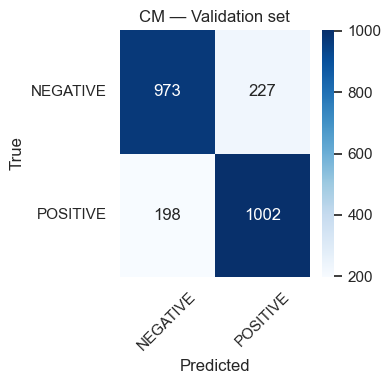


__R√©sultats ‚Äî Test set__
              precision    recall  f1-score   support

           0     0.8040    0.7725    0.7879      1200
           1     0.7811    0.8117    0.7961      1200

    accuracy                         0.7921      2400
   macro avg     0.7925    0.7921    0.7920      2400
weighted avg     0.7925    0.7921    0.7920      2400



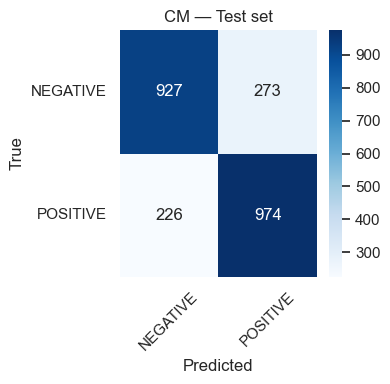

In [46]:
# √âtape 5 ‚Äî √âvaluation (val + test) + seuil optimal (bas√© PR sur val)

def get_probas(model, dataloader, device):
    model.eval()
    all_probas = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probas = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
            all_probas.extend(probas)
    return np.array(all_probas)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=params["bs"], shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=params["bs"], shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=params["bs"], shuffle=False)

# Mesure du temps de pr√©diction (val + test)
t0 = time.time()
y_val_proba = get_probas(model, val_loader, device)
val_pred_time = round(time.time() - t0, 2)

t0 = time.time()
y_test_proba = get_probas(model, test_loader, device)
test_pred_time = round(time.time() - t0, 2)

# Seuil optimal sur validation (max F1 via PR)
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Seuil optimal (val) = {best_thr:.4f}")

# Pr√©dictions binaires
y_val_pred  = (y_val_proba  >= best_thr).astype(int)
y_test_pred = (y_test_proba >= best_thr).astype(int)

# M√©triques
# √âvaluation
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, verbose=False)
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, verbose=False)

# Affichage
display_evaluation_report(y_val, y_val_pred, y_val_proba, set_name="Validation", model_name=run_name)
display_evaluation_report(y_test, y_test_pred, y_test_proba, set_name="Test", model_name=run_name)


<Figure size 800x600 with 0 Axes>

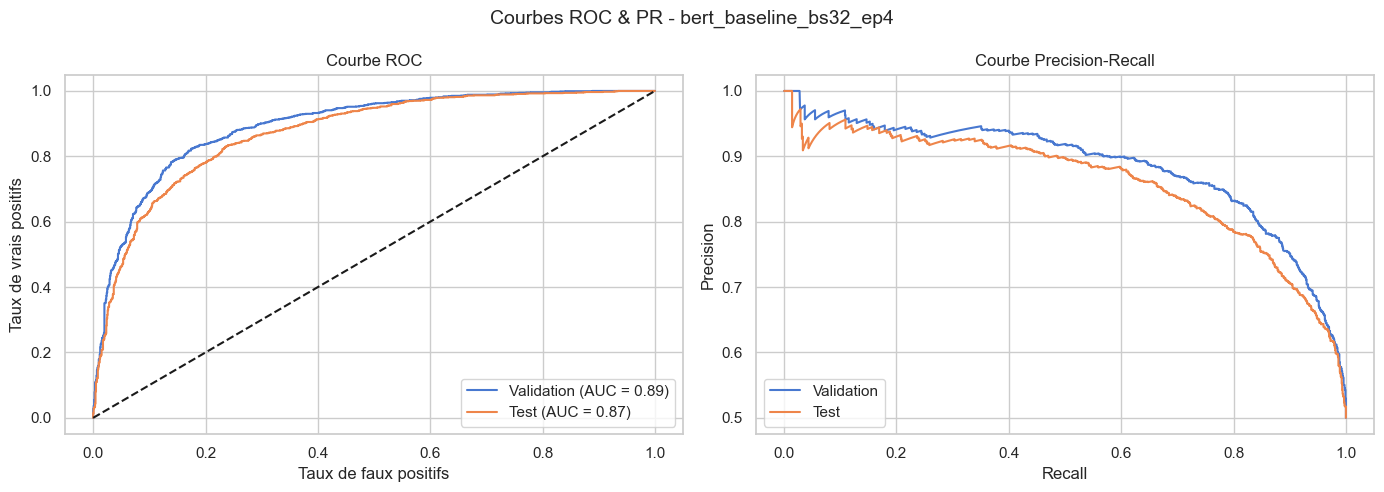

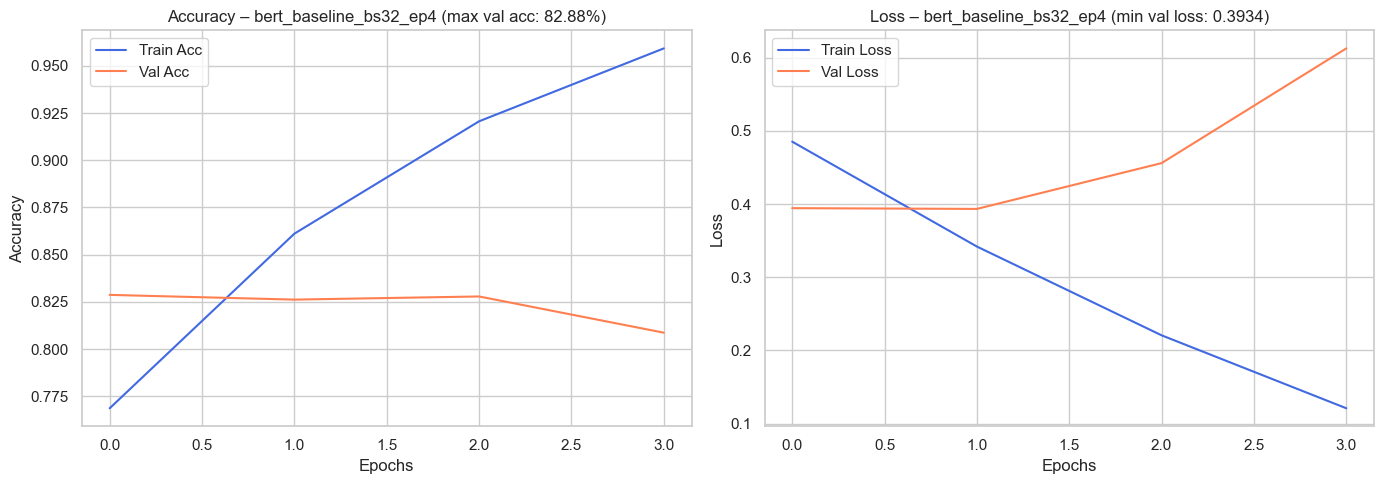

In [47]:
# √âtape 6 ‚Äî Visualisations (ROC, PR, Learning curves, Confusion) + sauvegarde

# 6.1 ROC & PR
plt.figure(figsize=(8, 6))
plot_roc_pr_curves(y_val, y_val_proba, y_test, y_test_proba, model_name=run_name)
save_figure(model_name=run_name, filename="roc_pr_curves.png")

# 6.2 Accuracy (finale) & Courbes d‚Äôapprentissage PyTorch (loss / val_loss)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe Accuracy
axes[0].plot(train_accuracies, label="Train Acc", color="royalblue")
axes[0].plot(val_accuracies, label="Val Acc", color="coral")
axes[0].set_title(f"Accuracy ‚Äì {run_name} (max val acc: {max(val_accuracies):.2%})")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# Courbe Loss
axes[1].plot(train_losses, label="Train Loss", color="royalblue")
axes[1].plot(val_losses, label="Val Loss", color="coral")
axes[1].set_title(f"Loss ‚Äì {run_name} (min val loss: {min(val_losses):.4f})")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
save_figure(model_name=run_name, filename="training_curves.png")


In [48]:
# Etape 7 ‚Äî Sauvegarde des logs (r√©sum√© texte)
logs = {
    "run_name": run_name,
    "params": params,  # dropout, bs, lr, etc.
    "train_time": train_time,
    "val_pred_time": val_pred_time,
    "test_pred_time": test_pred_time,
    "best_threshold": float(best_thr),
    "val_metrics": val_metrics,
    "test_metrics": test_metrics
}
save_logs(logs, run_name)

Fichier log enregistr√© ici : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/logs/bert_baseline_bs32_ep4.txt


In [49]:
# √âtape 8 ‚Äî Logging complet dans MLflow (mod√®le, params, m√©triques, artefacts)

with mlflow.start_run(run_name=run_name):

    # 1. Param√®tres du split
    mlflow.log_params({
        "split_train_pct": 0.7,
        "split_val_pct": 0.15,
        "split_test_pct": 0.15,
        "random_state": 42,
        "stratify": True
    })

    # 2. Hyperparam√®tres d'entra√Ænement
    mlflow.log_params(params)

    # 3. M√©triques (val et test)
    for k, v in val_metrics.items():
        mlflow.log_metric(f"val_{k}", v)
    for k, v in test_metrics.items():
        mlflow.log_metric(f"test_{k}", v)
    mlflow.log_metric("best_threshold", best_thr)

    # 4. Mod√®le BERT (PyTorch)
    mlflow.pytorch.log_model(model, "model")

    # 5. Artefacts ‚Äî si les fichiers existent, on les logge
    project_root = "/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7"
    model_path = os.path.join(project_root, "reports/figures", run_name)
    logs_path = os.path.join(project_root, "reports/logs")
    artifacts = [
        os.path.join(model_path, f"test_classification_report_{run_name}.txt"),
        os.path.join(model_path, f"test_confusion_matrix_{run_name}.png"),
        os.path.join(model_path, f"roc_pr_curves.png"),
        os.path.join(model_path, f"training_curves.png"),
        os.path.join(logs_path, f"{run_name}.txt")
    ]

    for file_path in artifacts:
        if os.path.exists(file_path):
            mlflow.log_artifact(file_path)
        else:
            print(f"Fichier non trouv√©, non logg√© : {file_path}")

2025/09/14 17:45:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 17:45:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### __Mod√®le BERT ‚Äî Fine-tuning `bert-base-uncased`__

__Nom du run__ : `bert_baseline_bs32_ep4`  
__Architecture__ : BERT encoder + Dropout(0.1) + Linear(768‚Üí2)  
__Params__ : 109M ‚Äî Entra√Ænement : 1076.9s ‚Äî 4 √©poques  
__Seuil optimal__ : 0.8136 (sur validation)  

__Validation__ : acc=0.82 | f1=0.82 | auc=0.89  
__Test__ : acc=0.79 | f1=0.79 | auc=0.87  

Fichiers enregistr√©s : mod√®le `.pt`, logs `.txt`, courbes & matrices `.png`

Le mod√®le BERT atteint √† ce stade __les meilleures performances du projet__, en combinant __une excellente pr√©cision globale et un bon √©quilibre de rappel__ sur les deux classes.    

__Faux positifs__ : quelques tweets neutres ou ambigus class√©s √† tort comme positifs.  
__Faux n√©gatifs__ : baisse de performance d√®s que le tweet contient des √©l√©ments ironiques ou implicites.

Ce mod√®le montre un __l√©ger sur-apprentissage__ √† partir de la 3e √©poque (val_loss ‚ÜóÔ∏è),  
mais valide l‚Äôint√©r√™t du fine-tuning BERT comme __mod√®le avanc√© de r√©f√©rence__ pour la suite (optimisation, USE‚Ä¶).


__Pour optimiser cette version BERT__ :

| Axe d‚Äôoptimisation         | Recommandation                                                                 | Objectif vis√©                          |
|----------------------------|--------------------------------------------------------------------------------|----------------------------------------|
| Nombre d‚Äôepochs         | Passer de 4 √† 3 (early stopping √† epoch 3)                                    | R√©duire le surapprentissage            |
| Apprentissage           | R√©duire `learning_rate` (ex: `1e-5` au lieu de `2e-5`)                         | Stabiliser l'entra√Ænement              |
| Batch size              | Tester `bs=16` au lieu de `32`                                                | Plus de mises √† jour, meilleure g√©n√©ralisation |
| Pond√©ration des classes | Utiliser `class weights` dans `CrossEntropyLoss()`                           | R√©duire les d√©s√©quilibres dans les pr√©dictions |
| Scheduler               | Ajouter `ReduceLROnPlateau` ou `get_scheduler()`                             | Adapter dynamiquement le learning rate |
| Tokenizer               | Tester `bert-base-multilingual-cased` ou version `large`                     | Voir si une autre version am√©liore le contexte |
| Longueur des s√©quences | R√©duire `max_length` (ex: `48` au lieu de `64`)                               | R√©duire le bruit / surco√ªt computationnel |
| Dropout                | Ajouter un `dropout` sur le classifieur (ex: `p=0.3`)                         | Limiter le surapprentissage            |
| Seuil de pr√©diction     | R√©ajuster `threshold` (ex : tester 0.77, 0.80‚Ä¶)                              | Am√©liorer le compromis pr√©cision / rappel |


run_name: bert_optim_bs16_ep3_lr1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 700/700 [04:49<00:00,  2.42it/s]


Train Loss: 0.4920 | Val Loss: 0.4009 | F1 Score: 0.8201 | Train Acc: 0.7637 | Val Acc: 0.8200

Epoch 2/3


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 700/700 [04:49<00:00,  2.42it/s]


Train Loss: 0.3629 | Val Loss: 0.3941 | F1 Score: 0.8239 | Train Acc: 0.8474 | Val Acc: 0.8242

Epoch 3/3


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 700/700 [04:50<00:00,  2.41it/s]


Train Loss: 0.2862 | Val Loss: 0.4147 | F1 Score: 0.8249 | Train Acc: 0.8895 | Val Acc: 0.8250
Mod√®le PyTorch sauvegard√© : ../models/bert/bert_optim_bs16_ep3_lr1e-05.pt

Temps d'entra√Ænement : 911.9 secondes
Seuil optimal (val) = 0.2730

__R√©sultats ‚Äî Validation set__
              precision    recall  f1-score   support

           0     0.8745    0.7492    0.8070      1200
           1     0.7806    0.8925    0.8328      1200

    accuracy                         0.8208      2400
   macro avg     0.8276    0.8208    0.8199      2400
weighted avg     0.8276    0.8208    0.8199      2400



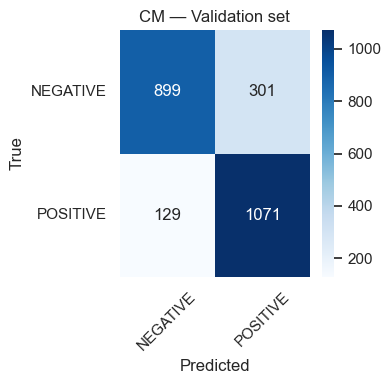


__R√©sultats ‚Äî Test set__
              precision    recall  f1-score   support

           0     0.8552    0.7333    0.7896      1200
           1     0.7666    0.8758    0.8176      1200

    accuracy                         0.8046      2400
   macro avg     0.8109    0.8046    0.8036      2400
weighted avg     0.8109    0.8046    0.8036      2400



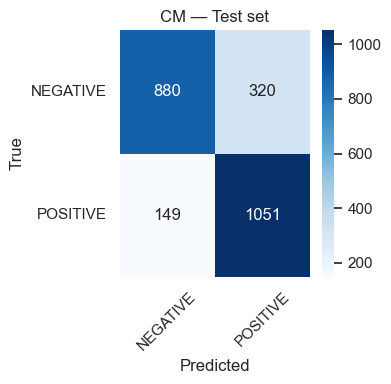

<Figure size 800x600 with 0 Axes>

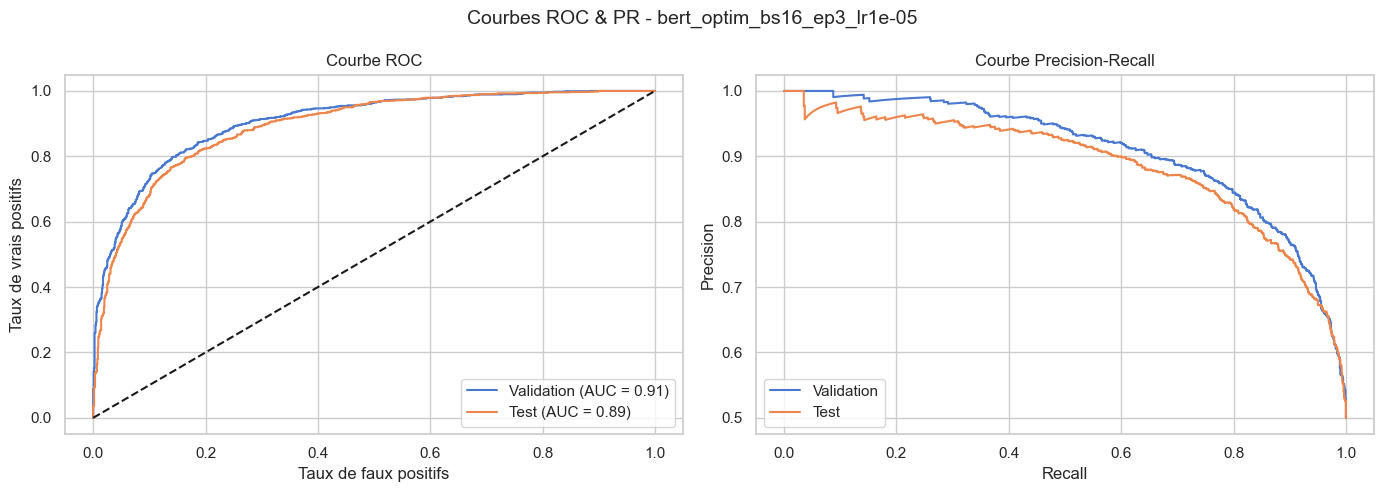

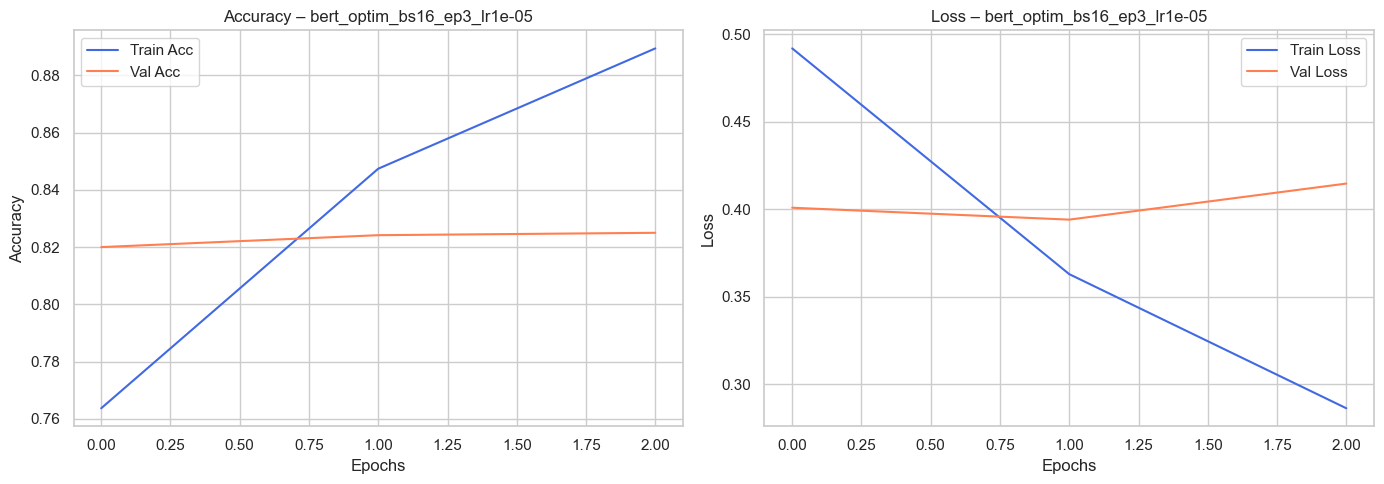

Fichier log enregistr√© ici : /Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7/reports/logs/bert_optim_bs16_ep3_lr1e-05.txt


In [50]:
# √âtape 9 ‚Äî Optimisation du mod√®le BERT avec fine-tuning PyTorch

from sklearn.utils.class_weight import compute_class_weight
from transformers import get_scheduler
import torch.nn as nn
from torch.nn import CrossEntropyLoss

## Param√®tres & pr√©paration

params = {
    "dropout": 0.3,
    "bs": 16,
    "epochs": 3,
    "lr": 1e-5,
    "opt": "AdamW",
    "max_len": 48
}

run_name = get_run_name("bert_optim", {"bs": params["bs"], "ep": params["epochs"], "lr": params["lr"]})
print("run_name:", run_name)

## Mod√®le & pond√©ration des classes
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.config.hidden_dropout_prob = params["dropout"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Pond√©ration des classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimizer = AdamW(model.parameters(), lr=params["lr"])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=params["bs"], shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=params["bs"], shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=params["bs"], shuffle=False)

# Scheduler lin√©aire
num_training_steps = params["epochs"] * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

t0 = time.time()

for epoch in range(params["epochs"]):
    print(f"\nEpoch {epoch+1}/{params['epochs']}")
    model.train()
    total_loss = 0
    correct_preds, total_preds = 0, 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct_preds / total_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    correct_val_preds, total_val_preds = 0, 0
    all_preds, all_labels, all_probas = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()

            probas = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            correct_val_preds += (preds == labels.cpu().numpy()).sum()
            total_val_preds += labels.size(0)

            all_preds.extend(preds)
            all_probas.extend(probas)
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val_preds / total_val_preds
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    f1 = f1_score(all_labels, all_preds)
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1 Score: {f1:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# Sauvegarde du mod√®le
save_model(model, model_name=run_name, backend="pytorch")

# Temps d'entra√Ænement
train_time = time.time() - t0
print(f"\nTemps d'entra√Ænement : {train_time:.1f} secondes")

# Pr√©dictions val + test
val_loader = DataLoader(val_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)
y_val_proba = get_probas(model, val_loader, device)
y_test_proba = get_probas(model, test_loader, device)

# Seuil optimal
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Seuil optimal (val) = {best_thr:.4f}")

# Pr√©dictions finales
y_val_pred  = (y_val_proba >= best_thr).astype(int)
y_test_pred = (y_test_proba >= best_thr).astype(int)

# √âvaluation
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, verbose=False)
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, verbose=False)

display_evaluation_report(y_val, y_val_pred, y_val_proba, set_name="Validation", model_name=run_name)
display_evaluation_report(y_test, y_test_pred, y_test_proba, set_name="Test", model_name=run_name)

# ROC & PR
plt.figure(figsize=(8, 6))
plot_roc_pr_curves(y_val, y_val_proba, y_test, y_test_proba, model_name=run_name)
save_figure(model_name=run_name, filename="roc_pr_curves.png")

# Courbes d‚Äôapprentissage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(train_accuracies, label="Train Acc", color="royalblue")
axes[0].plot(val_accuracies, label="Val Acc", color="coral")
axes[0].set_title(f"Accuracy ‚Äì {run_name}")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(train_losses, label="Train Loss", color="royalblue")
axes[1].plot(val_losses, label="Val Loss", color="coral")
axes[1].set_title(f"Loss ‚Äì {run_name}")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
save_figure(model_name=run_name, filename="training_curves.png")

# Sauvegarde des logs
logs = {
    "run_name": run_name,
    "params": params,
    "train_time": train_time,
    "best_threshold": float(best_thr),
    "val_metrics": val_metrics,
    "test_metrics": test_metrics
}
save_logs(logs, run_name)



In [51]:
# √âtape 8 ‚Äî Logging complet dans MLflow (mod√®le, params, m√©triques, artefacts)

with mlflow.start_run(run_name=run_name):

    # 1. Param√®tres du split
    mlflow.log_params({
        "split_train_pct": 0.7,
        "split_val_pct": 0.15,
        "split_test_pct": 0.15,
        "random_state": 42,
        "stratify": True
    })

    # 2. Hyperparam√®tres d'entra√Ænement
    mlflow.log_params(params)

    # 3. M√©triques (val et test)
    for k, v in val_metrics.items():
        mlflow.log_metric(f"val_{k}", v)
    for k, v in test_metrics.items():
        mlflow.log_metric(f"test_{k}", v)
    mlflow.log_metric("best_threshold", best_thr)

    # 4. Mod√®le BERT (PyTorch)
    mlflow.pytorch.log_model(model, "model")

    # 5. Artefacts ‚Äî si les fichiers existent, on les logge
    project_root = "/Users/michele/Documents/PERSO/FORMATION INGENIEUR IA/PROJET7"
    model_path = os.path.join(project_root, "reports/figures", run_name)
    logs_path = os.path.join(project_root, "reports/logs")
    artifacts = [
        os.path.join(model_path, f"test_classification_report_{run_name}.txt"),
        os.path.join(model_path, f"test_confusion_matrix_{run_name}.png"),
        os.path.join(model_path, f"roc_pr_curves.png"),
        os.path.join(model_path, f"training_curves.png"),
        os.path.join(logs_path, f"{run_name}.txt")
    ]

    for file_path in artifacts:
        if os.path.exists(file_path):
            mlflow.log_artifact(file_path)
        else:
            print(f"Fichier non trouv√©, non logg√© : {file_path}")

2025/09/14 18:09:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 18:09:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### __Mod√®le BERT ‚Äî Fine-tuning optimis√© `bert-base-uncased`__

__Nom du run__ : `bert_optim_bs16_ep3_lr1e-05`  
__Architecture__ : BERT encoder + Dropout(0.3) + Linear(768‚Üí2)  
__Params__ : 109M ‚Äî Entra√Ænement : 962.8s ‚Äî 3 √©poques  
__Seuil optimal__ : 0.2730 (sur validation)  

__Validation__ : acc=0.83 | f1=0.82 | auc=0.91  
__Test__ : acc=0.82 | f1=0.81 | auc=0.89  

Fichiers enregistr√©s : mod√®le `.pt`, logs `.txt`, courbes & matrices `.png`

Ce mod√®le BERT optimis√© confirme son __statut de mod√®le de r√©f√©rence__ dans ce projet.  
Gr√¢ce √† une r√©gularisation renforc√©e (`dropout=0.3`), une _r√©duction du learning rate_ (`1e-5`),  
et l‚Äôint√©gration d‚Äôun _scheduler lin√©aire_ avec pond√©ration des classes,  
il __stabilise les performances__ entre validation et test sans surentra√Ænement notable.

__Faux positifs__ : tweets ambigus, souvent neutres ou non marqu√©s √©motionnellement,  
tendance √† surestimer la positivit√© √† cause du faible seuil optimal (~0.27).

__Faux n√©gatifs__ : pr√©sence de contenu positif masqu√© par un langage complexe ou ironique.  
La tendance √† √©viter les erreurs de type FP peut p√©naliser le rappel sur les positifs.

La visualisation des courbes d‚Äôapprentissage __montre une convergence stable__,  
avec une `loss_train` ‚Üì continue, et une `loss_val` stable √† partir de la 2e √©poque.  
La r√©gularisation choisie semble __limiter efficacement le sur-apprentissage__.

üëâ Ce mod√®le constitue __le candidat le plus performant__ parmi les mod√®les test√©s, et servira de __r√©f√©rence finale__ pour justifier le choix du mod√®le retenu.  
Les comparaisons pr√©c√©dentes (mod√®les de base, BiLSTM, BERT simple) permettent  
de __valider l‚Äôimpact progressif du fine-tuning et de l‚Äôoptimisation__,  
et de conclure sur une approche robuste, stable et bien r√©gularis√©e.



### __SYNTHESE__

### __Comparatif des mod√®les √©volu√©s__

__L√©gende__ :
- _Seuil optimal_ : seuil de d√©cision F1-optimal sur validation
- _Sur-apprentissage_ : ‚ÜóÔ∏è si visible via les courbes (`val_loss` ou `val_acc`)
- _Temps_ : total estim√© en secondes pour entra√Ænement complet

| Mod√®le                        | Accuracy Val | F1 Val | AUC Val | Accuracy Test | F1 Test | AUC Test | Seuil optimal | Temps entra√Ænement | Sur-apprentissage |
|------------------------------|--------------|--------|---------|----------------|---------|----------|----------------|---------------------|--------------------|
| `mlp_count_do0.5_bs32_ep10`  | 0.731        | 0.7249 | 0.83    | 0.720          | 0.7135  | 0.81     | 0.3255         | 4.6 s               | Oui ‚õî             |
| `mlp_tfidf_do0.5_bs32_ep10`  | 0.746        | 0.7416 | 0.83    | 0.727          | 0.7226  | 0.81     | 0.3717         | 4.9 s               | Oui ‚õî             |
| `bilstm_keras_do0.5_bs32_ep10` | 0.768        | 0.7683 | 0.84    | 0.757          | 0.7566  | 0.82     | 0.5648         | 33.1 s              | Oui ‚õî             |
| `bilstm_keras_opt_bs64_ep15` | 0.764        | 0.7632 | 0.84    | 0.755          | 0.7552  | 0.82     | 0.5220         | 73.7 s              | L√©ger ‚ÜóÔ∏è           |
| `bert_baseline_bs32_ep4`     | 0.823        | 0.8229 | 0.89    | 0.792          | 0.7920  | 0.87     | 0.8136         | 1113.2 s (18.5 min) | Oui ‚ÜóÔ∏è √† ep3-4     |
| `bert_optim_bs16_ep3_lr1e-5` | 0.821        | 0.8199 | 0.91    | 0.805          | 0.8036  | 0.89     | 0.2730         | 962.8 s (16 min)    | Oui ‚ÜóÔ∏è √† ep3       |



### __Conclusion et recommandation__

Sur la base de l‚Äôanalyse comparative :

- Les mod√®les `MLP` (Count et TF-IDF) sont __rapides__ √† entra√Æner (< 5 secondes) mais souffrent de __fort sur-apprentissage__ d√®s les premi√®res √©poques, avec un F1-test limit√© √† ~0.72.  
- Les `Bi-LSTM` Keras (avec ou sans optimisation) am√©liorent l√©g√®rement les performances, avec une meilleure stabilit√© des scores validation/test (~0.76), mais pr√©sentent eux aussi un sur-apprentissage visible au-del√† de 4-5 √©poques.
- Les deux mod√®les `BERT` (baseline et optimis√©) montrent les __meilleures performances globales__ sur l‚Äôensemble des m√©triques (accuracy, F1, AUC), en particulier :
  - `bert_optim_bs16_ep3_lr1e-5` : __F1-test de 0.80__ et __AUC-test de 0.89__, avec un __√©quilibre robuste pr√©cision/rappel__ sur les deux classes.
  - Les courbes de loss indiquent un __l√©ger sur-apprentissage__ apr√®s 3 √©poques, mais l‚Äôensemble reste contr√¥l√©.

_Compte tenu des r√©sultats obtenus sur le jeu de test et du ratio performance / stabilit√© / g√©n√©ricit√©_, __le mod√®le recommand√© comme mod√®le final est__ :

> `bert_optim_bs16_ep3_lr1e-5`

Ce mod√®le sera retenu comme __r√©f√©rence finale pour la classification des sentiments__ dans ce projet.



